In [1]:
import os

if not os.path.exists("datasets/"):
    os.mkdir("datasets")

In [2]:
!wget --header="User-Agent: Mozilla/5.0" -O datasets/steam_reviews.json.gz http://cseweb.ucsd.edu/~wckang/steam_reviews.json.gz
!wget --header="User-Agent: Mozilla/5.0" -O datasets/steam_games.json.gz http://cseweb.ucsd.edu/~wckang/steam_games.json.gz

--2025-11-17 10:38:03--  http://cseweb.ucsd.edu/~wckang/steam_reviews.json.gz
Resolving cseweb.ucsd.edu (cseweb.ucsd.edu)... 132.239.8.30
Connecting to cseweb.ucsd.edu (cseweb.ucsd.edu)|132.239.8.30|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cseweb.ucsd.edu//~wckang/steam_reviews.json.gz [following]
--2025-11-17 10:38:04--  https://cseweb.ucsd.edu//~wckang/steam_reviews.json.gz
Connecting to cseweb.ucsd.edu (cseweb.ucsd.edu)|132.239.8.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1338063248 (1.2G) [application/x-gzip]
Saving to: ‘datasets/steam_reviews.json.gz’

datasets/steam_revi 100%[===================>]   1.25G  4.22MB/s    in 2m 58s  

2025-11-17 10:41:02 (7.17 MB/s) - ‘datasets/steam_reviews.json.gz’ saved [1338063248/1338063248]

--2025-11-17 10:41:03--  http://cseweb.ucsd.edu/~wckang/steam_games.json.gz
Resolving cseweb.ucsd.edu (cseweb.ucsd.edu)... 132.239.8.30
Connecting to cseweb.ucsd.edu (cseweb.ucsd

In [3]:
import gzip
import shutil

# Ruta del archivo .gz
gz_path = "datasets/steam_games.json.gz"

# Ruta de destino sin compresión
output_path = "datasets/steam_games.json"

# Descomprimir
with gzip.open(gz_path, 'rb') as f_in:
    with open(output_path, 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)


# Ruta del archivo .gz
gz_path = "datasets/steam_reviews.json.gz"

# Ruta de destino sin compresión
output_path = "datasets/steam_new.json"

# Descomprimir
with gzip.open(gz_path, 'rb') as f_in:
    with open(output_path, 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)


In [1]:
#codigo para cargar los datos en 2 df, uno para el game_info y otro para las reviews

import pandas as pd
import ast

def json_line_generator(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if line:
                data_object = ast.literal_eval(line)
                yield data_object


df_games = pd.DataFrame(json_line_generator("datasets/steam_games.json"))
df_reviews = pd.DataFrame(json_line_generator("datasets/steam_new.json"))
print("Número total de registros cargados en df_games:", len(df_games))

print("\nNúmero total de registros cargados en df_reviews:", len(df_reviews))

Número total de registros cargados en df_games: 32135

Número total de registros cargados en df_reviews: 7793069


In [2]:
#poner una columna de el nombre del juego en el df de reviews
df_games_info = df_games[['id', 'title']].rename(columns={'id': 'product_id', 'title': 'game_title'})
df_reviews = pd.merge(
    df_reviews,                       
    df_games_info,                    
    on='product_id',                  
    how='left'                        
)

In [3]:
#verificación
df_reviews.head(5)

,username,hours,products,product_id,page_order,date,text,early_access,page,found_funny,compensation,user_id,game_title
0,Chaos Syren,0.1,41.0,725280,0,2017-12-17,This would not be acceptable as an entertainme...,False,1,NaN,NaN,NaN,Psi Project
1,₮ʜᴇ Wᴀʀᴛᴏɴ,51.1,769.0,328100,0,2017-12-27,looks like a facebook game,False,1,NaN,NaN,NaN,Gunspell - Steam Edition
2,hello?<,14.6,2.0,328100,1,2017-10-16,Better than Minecraft,False,1,2.0,Product received for free,NaN,Gunspell - Steam Edition
3,Cyderine916,5.0,64.0,35140,0,2018-01-04,I love and idolized Batman and this game is Ma...,False,1,NaN,NaN,NaN,Batman: Arkham Asylum Game of the Year Edition
4,DarklyThinking,16.6,577.0,35140,1,2018-01-04,Still worth playing in 2018.\nProbably my favo...,False,1,NaN,NaN,76561198007483075,Batman: Arkham Asylum Game of the Year Edition


In [3]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

def preprocess_text(text):
    if text is None or text == "":
        return []
    
    #minuscula + ruido
    text = str(text).lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE) #URLs
    text = re.sub(r'<.*?>', '', text)       #etiquetas HTML
    text = re.sub(r'[^a-záéíóúüñ\s]', '', text) #caracteres no alfabéticos 

    #tokenizacion
    tokens = word_tokenize(text)
    
    #stopwords 
    spanish_stopwords = set(stopwords.words('spanish'))
    english_stopwords = set(stopwords.words('english'))
    all_stopwords = spanish_stopwords.union(english_stopwords)

    filtered_tokens = [word for word in tokens if word not in all_stopwords and len(word) > 1]
    
    return filtered_tokens

df_reviews['processed_tokens'] = df_reviews['text'].apply(preprocess_text)
df_reviews['processed_text'] = df_reviews['processed_tokens'].apply(lambda x: ' '.join(x))

In [4]:
df_reviews.to_csv("datasets/df_reviews.csv")
df_games_info.to_csv("datasets/df_games.csv")

In [6]:
df_reviews.head(5)

,username,hours,products,product_id,page_order,date,text,early_access,page,found_funny,compensation,user_id,game_title,processed_tokens,processed_text
0,Chaos Syren,0.1,41.0,725280,0,2017-12-17,This would not be acceptable as an entertainme...,False,1,NaN,NaN,NaN,Psi Project,"[would, acceptable, entertainment, even, back,...",would acceptable entertainment even back day g...
1,₮ʜᴇ Wᴀʀᴛᴏɴ,51.1,769.0,328100,0,2017-12-27,looks like a facebook game,False,1,NaN,NaN,NaN,Gunspell - Steam Edition,"[looks, like, facebook, game]",looks like facebook game
2,hello?<,14.6,2.0,328100,1,2017-10-16,Better than Minecraft,False,1,2.0,Product received for free,NaN,Gunspell - Steam Edition,"[better, minecraft]",better minecraft
3,Cyderine916,5.0,64.0,35140,0,2018-01-04,I love and idolized Batman and this game is Ma...,False,1,NaN,NaN,NaN,Batman: Arkham Asylum Game of the Year Edition,"[love, idolized, batman, game, masterpiece]",love idolized batman game masterpiece
4,DarklyThinking,16.6,577.0,35140,1,2018-01-04,Still worth playing in 2018.\nProbably my favo...,False,1,NaN,NaN,76561198007483075,Batman: Arkham Asylum Game of the Year Edition,"[still, worth, playing, probably, favorite, ba...",still worth playing probably favorite batman g...


Número total de reviews procesadas: 7671591
Loss after epoch 0: 63260836.0
Loss after epoch 1: 12421796.0
Loss after epoch 2: 9208928.0
Loss after epoch 3: 9110032.0
Loss after epoch 4: 8648680.0
Loss after epoch 5: 8219208.0
Loss after epoch 6: 7562432.0
Loss after epoch 7: 6936832.0
Loss after epoch 8: 6041752.0
Loss after epoch 9: 2807232.0

Vocabulario construido con 257921 palabras únicas


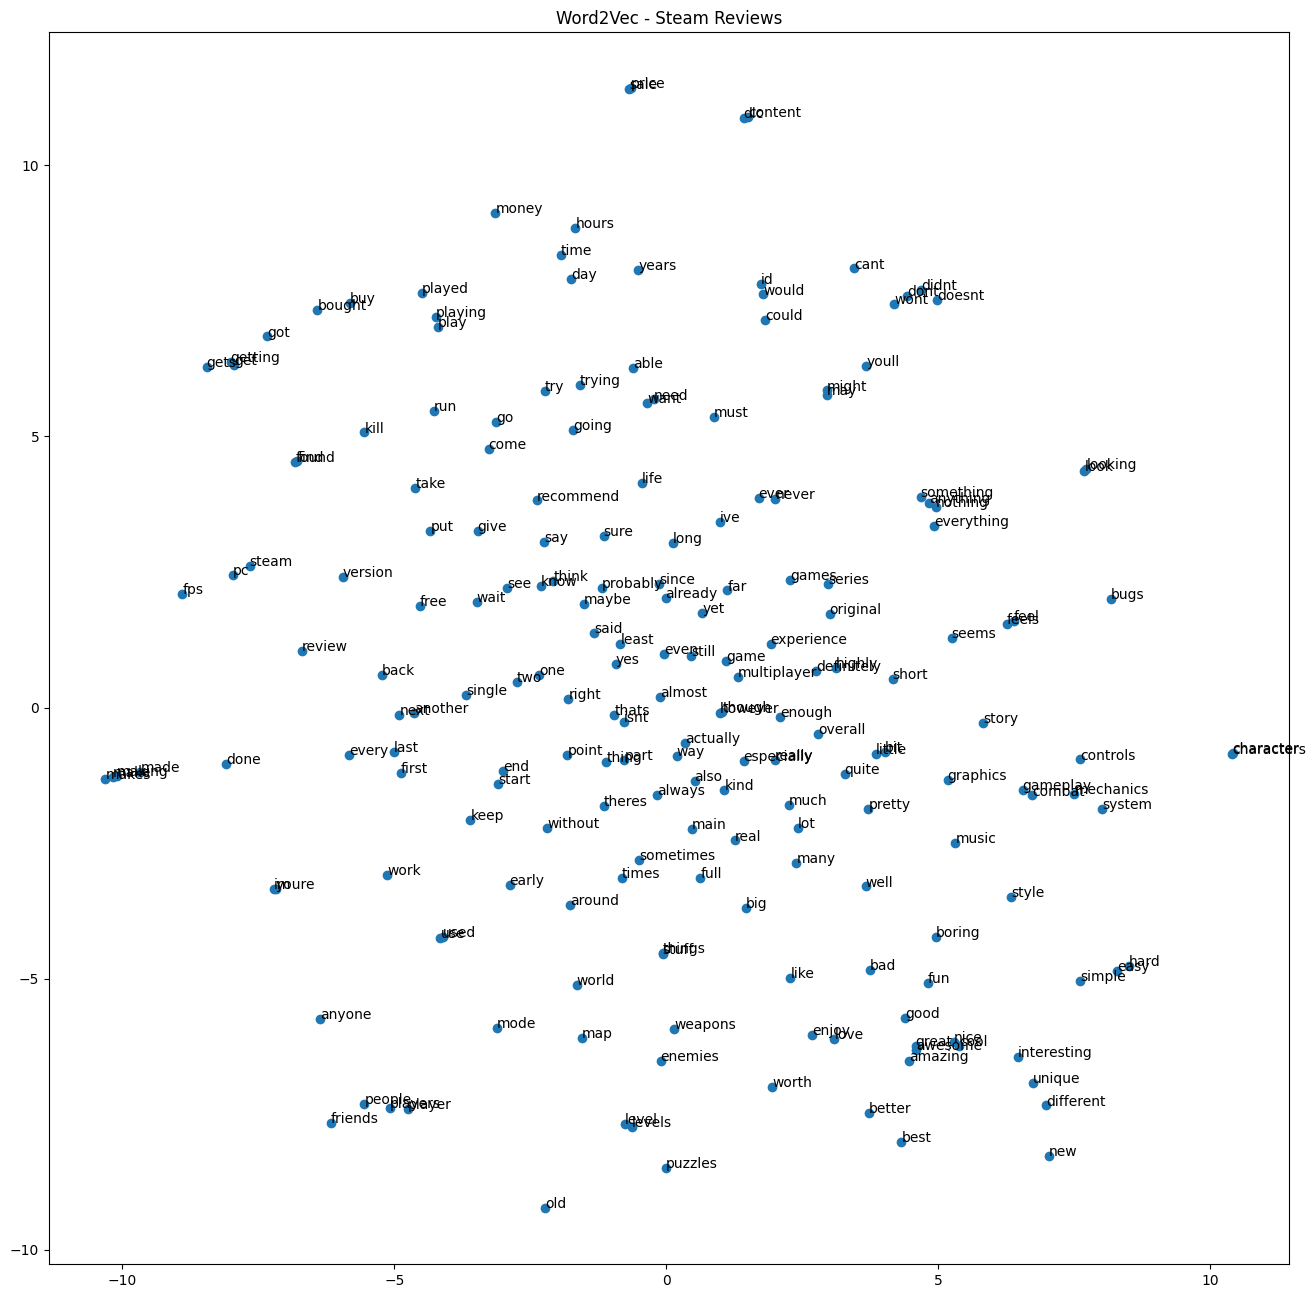

In [9]:
#Crear word2vec con los tokens procesados

import gensim.models
from gensim.models.callbacks import CallbackAny2Vec
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


class EpochLogger(CallbackAny2Vec):
    '''Callback to log information about training'''

    def __init__(self):
        self.epoch = 0

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        if self.epoch == 0:
            print('Loss after epoch {}: {}'.format(self.epoch, loss))
        else:
            print('Loss after epoch {}: {}'.format(self.epoch, loss - self.loss_previous_step))
        self.epoch += 1
        self.loss_previous_step = loss

sentences = [tokens for tokens in df_reviews['processed_tokens'].values if len(tokens) > 0]

print(f"Número total de reviews procesadas: {len(sentences)}")

#crear Word2Vec
epoch_logger = EpochLogger()

model = gensim.models.Word2Vec(
    sentences=sentences, 
    vector_size=200, 
    window=5, 
    min_count=5,  
    compute_loss=True, 
    callbacks=[epoch_logger], 
    negative=5, 
    epochs=10,  
    workers=4  
    
)

print(f"\nVocabulario construido con {len(model.wv)} palabras únicas")

# Visualización con TSNE
# Selecciona las primeras 200 palabras más frecuentes
words = list(model.wv.index_to_key)[:200]
vectors = [model.wv[word] for word in words]

# Aplica TSNE
tsne = TSNE(n_components=2, random_state=0, perplexity=30)
tsne_vectors = tsne.fit_transform(np.array(vectors))

plt.figure(figsize=(16, 16))
plt.scatter(tsne_vectors[:, 0], tsne_vectors[:, 1])

for i, word in enumerate(words):
    plt.annotate(word, (tsne_vectors[i, 0], tsne_vectors[i, 1]))

plt.title('Word2Vec - Steam Reviews')
plt.show()



In [10]:
#ejemplos
print("\nEjemplos de palabras similares")
test_words = ['game', 'good', 'bad', 'fun', 'play']
for word in test_words:
    if word in model.wv:
        print(f"\nPalabras similares a '{word}':")
        similar = model.wv.most_similar(word, topn=5)
        for similar_word, score in similar:
            print(f"  {similar_word}: {score:.4f}")


Ejemplos de palabras similares

Palabras similares a 'game':
  gameit: 0.5670
  title: 0.5646
  games: 0.5626
  gamebut: 0.5201
  however: 0.5200

Palabras similares a 'good':
  great: 0.7974
  decent: 0.7963
  nice: 0.7110
  awesome: 0.6665
  solid: 0.6453

Palabras similares a 'bad':
  terrible: 0.7667
  horrible: 0.7192
  awful: 0.6766
  good: 0.6362
  poor: 0.6351

Palabras similares a 'fun':
  enjoyable: 0.7237
  entertaining: 0.6913
  addicting: 0.6400
  addictive: 0.5917
  funthe: 0.5543

Palabras similares a 'play':
  playing: 0.6823
  paly: 0.6720
  toaround: 0.5461
  playbut: 0.5084
  played: 0.4960


In [11]:
#guardar modelo
import os
if not os.path.exists("modelos/"):
    os.mkdir("modelos")
model.save("modelos/steam_reviews_w2v_model")
print("\nModelo guardado como 'steam_reviews_w2v_model'")


Modelo guardado como 'steam_reviews_w2v_model'


In [12]:
import numpy as np
from tqdm import tqdm

print("Creando vectores de documento para cada review...")

def vectorize_documents(tokens_series, model):
    """
    Método más rápido: procesamiento vectorizado con numpy
    """
    vector_size = model.vector_size
    n_docs = len(tokens_series)
    
    # Pre-alocar array para mejor rendimiento
    doc_vectors = np.zeros((n_docs, vector_size), dtype=np.float32)
    
    # Procesar con barra de progreso
    for i, tokens in enumerate(tqdm(tokens_series, desc="Vectorizando")):
        if tokens:
            # Obtener vectores válidos de una vez
            valid_vectors = np.array([model.wv[token] for token in tokens if token in model.wv])
            
            if len(valid_vectors) > 0:
                doc_vectors[i] = valid_vectors.mean(axis=0)
    
    return doc_vectors

# Aplicar
doc_vectors = vectorize_documents(df_reviews['processed_tokens'], model)
np.save('datasets/review_vectors.npy', doc_vectors)  
del doc_vectors  


Creando vectores de documento para cada review...


Vectorizando: 100%|██████████| 7799538/7799538 [04:58<00:00, 26168.56it/s]


In [13]:
df_reviews.head(5)

,username,hours,products,product_id,page_order,date,text,early_access,page,found_funny,compensation,user_id,game_title,processed_tokens,processed_text
0,Chaos Syren,0.1,41.0,725280,0,2017-12-17,This would not be acceptable as an entertainme...,False,1,NaN,NaN,NaN,Psi Project,"[would, acceptable, entertainment, even, back,...",would acceptable entertainment even back day g...
1,₮ʜᴇ Wᴀʀᴛᴏɴ,51.1,769.0,328100,0,2017-12-27,looks like a facebook game,False,1,NaN,NaN,NaN,Gunspell - Steam Edition,"[looks, like, facebook, game]",looks like facebook game
2,hello?<,14.6,2.0,328100,1,2017-10-16,Better than Minecraft,False,1,2.0,Product received for free,NaN,Gunspell - Steam Edition,"[better, minecraft]",better minecraft
3,Cyderine916,5.0,64.0,35140,0,2018-01-04,I love and idolized Batman and this game is Ma...,False,1,NaN,NaN,NaN,Batman: Arkham Asylum Game of the Year Edition,"[love, idolized, batman, game, masterpiece]",love idolized batman game masterpiece
4,DarklyThinking,16.6,577.0,35140,1,2018-01-04,Still worth playing in 2018.\nProbably my favo...,False,1,NaN,NaN,76561198007483075,Batman: Arkham Asylum Game of the Year Edition,"[still, worth, playing, probably, favorite, ba...",still worth playing probably favorite batman g...


In [14]:
from transformers import BertTokenizer, BertModel
import torch
from tqdm import tqdm
import numpy as np
import gc

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
model.eval()
print(f"Usando dispositivo: {device}")

# Habilitar optimizaciones
if device.type == 'cuda':
    torch.backends.cudnn.benchmark = True
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"VRAM disponible: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

def get_bert_embeddings_batch(texts_batch):
    inputs = tokenizer(texts_batch, return_tensors='pt', truncation=True, 
                      padding=True, max_length=128)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    with torch.no_grad():
        outputs = model(**inputs)
    
    return outputs.last_hidden_state[:, 0, :].cpu().numpy()

# TOMAR MUESTRA DE 1M REVIEWS
SAMPLE_SIZE = 1000000
print(f"\nSeleccionando muestra aleatoria de {SAMPLE_SIZE:,} reviews...")
sample_indices = np.random.choice(len(df_reviews), SAMPLE_SIZE, replace=False)
texts = df_reviews.iloc[sample_indices]['processed_text'].tolist()

# PROCESAMIENTO OPTIMIZADO
batch_size = 128
total_batches = (len(texts) + batch_size - 1) // batch_size

print(f"Procesando {len(texts):,} reviews en batches de {batch_size}")
print(f"Total de batches: {total_batches:,}")

embeddings = []

# Guardar por chunks
chunk_size = 100000
current_chunk = []
chunk_num = 0

for i in tqdm(range(0, len(texts), batch_size), desc="BERT embeddings", total=total_batches):
    batch = texts[i:i + batch_size]
    batch_embeddings = get_bert_embeddings_batch(batch)
    current_chunk.extend(batch_embeddings)
    
    # Guardar checkpoint cada 100k
    if len(current_chunk) >= chunk_size:
        embeddings.extend(current_chunk)
        
        np.save(f'datasets/bert_embeddings_chunk_{chunk_num}.npy', np.array(current_chunk))
        print(f"\n✅ Checkpoint: chunk {chunk_num} ({len(embeddings):,} procesadas)")
        
        current_chunk = []
        chunk_num += 1
        gc.collect()
        if device.type == 'cuda':
            torch.cuda.empty_cache()

# Guardar último chunk
if current_chunk:
    embeddings.extend(current_chunk)
    np.save(f'datasets/bert_embeddings_chunk_{chunk_num}.npy', np.array(current_chunk))

# Guardar todo junto
print("\nGuardando embeddings finales...")
np.save('datasets/bert_embeddings_1M.npy', np.array(embeddings))
np.save('datasets/bert_sample_indices.npy', sample_indices)

print(f"\n{len(embeddings):,} embeddings BERT generados")
print("Archivos guardados:")
print("  - datasets/bert_embeddings_1M.npy (embeddings)")
print("  - datasets/bert_sample_indices.npy (índices de la muestra)")
print("\nPara usar después:")
print("bert_embeds = np.load('datasets/bert_embeddings_1M.npy')")
print("indices = np.load('datasets/bert_sample_indices.npy')")
print("df_sample = df_reviews.iloc[indices]")

2025-11-17 11:29:38.850365: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-17 11:29:41.924808: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-17 11:29:44.158448: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Usando dispositivo: cuda
GPU: NVIDIA GeForce RTX 4060
VRAM disponible: 8.59 GB

Seleccionando muestra aleatoria de 1,000,000 reviews...
Procesando 1,000,000 reviews en batches de 128
Total de batches: 7,813


BERT embeddings:  10%|█         | 782/7813 [06:04<4:17:29,  2.20s/it]


✅ Checkpoint: chunk 0 (100,096 procesadas)


BERT embeddings:  20%|██        | 1564/7813 [12:07<3:56:15,  2.27s/it]


✅ Checkpoint: chunk 1 (200,192 procesadas)


BERT embeddings:  30%|███       | 2346/7813 [18:14<5:21:53,  3.53s/it]


✅ Checkpoint: chunk 2 (300,288 procesadas)


BERT embeddings:  40%|████      | 3128/7813 [24:18<3:24:12,  2.62s/it]


✅ Checkpoint: chunk 3 (400,384 procesadas)


BERT embeddings:  50%|█████     | 3910/7813 [30:22<2:49:06,  2.60s/it]


✅ Checkpoint: chunk 4 (500,480 procesadas)


BERT embeddings:  60%|██████    | 4692/7813 [36:26<2:15:36,  2.61s/it]


✅ Checkpoint: chunk 5 (600,576 procesadas)


BERT embeddings:  70%|███████   | 5474/7813 [42:31<1:37:29,  2.50s/it]


✅ Checkpoint: chunk 6 (700,672 procesadas)


BERT embeddings:  80%|████████  | 6256/7813 [48:40<1:39:13,  3.82s/it]


✅ Checkpoint: chunk 7 (800,768 procesadas)


BERT embeddings:  90%|█████████ | 7038/7813 [54:50<30:13,  2.34s/it]  


✅ Checkpoint: chunk 8 (900,864 procesadas)


BERT embeddings: 100%|██████████| 7813/7813 [1:00:49<00:00,  2.14it/s]



Guardando embeddings finales...

✅ 1,000,000 embeddings BERT generados
Archivos guardados:
  - datasets/bert_embeddings_1M.npy (embeddings)
  - datasets/bert_sample_indices.npy (índices de la muestra)

Para usar después:
bert_embeds = np.load('datasets/bert_embeddings_1M.npy')
indices = np.load('datasets/bert_sample_indices.npy')
df_sample = df_reviews.iloc[indices]


In [7]:
import numpy as np
bert_embeds = np.load('datasets/bert_embeddings_1M.npy')
indices = np.load('datasets/bert_sample_indices.npy')
df_sample = df_reviews.iloc[indices]
df_sample.head(5)

,username,hours,products,product_id,page_order,date,text,early_access,page,found_funny,compensation,user_id,game_title,processed_tokens,processed_text
4475199,Totoro,4.2,22.0,319510,7,2014-08-30,3spooky5me,False,1203,2.0,NaN,76561198044036862,Five Nights at Freddy's,[spookyme],spookyme
3048769,Tankred,55.7,272.0,201810,9,2014-06-19,Killing nazis has never been so fun!,False,1431,NaN,NaN,NaN,Wolfenstein: The New Order,"[killing, nazis, never, fun]",killing nazis never fun
3191772,BearpunchGunsmoke,0.6,99.0,237630,5,2013-12-28,DUCK TALES! WOO OOH!,False,159,NaN,NaN,NaN,DuckTales: Remastered,"[duck, tales, woo, ooh]",duck tales woo ooh
2489505,DevilDawn,22.6,292.0,228300,8,2014-03-25,A disturbing story about losing - or gaining -...,False,346,NaN,NaN,76561197993339440,Remember Me,"[disturbing, story, losing, gaining, memory, w...",disturbing story losing gaining memory whim on...
7573140,Serious Table,21.8,313.0,241600,8,2014-01-12,"It comes recommended, but BUYER BEWARE: A very...",False,678,NaN,NaN,NaN,Rogue Legacy,"[comes, recommended, buyer, beware, certain, t...",comes recommended buyer beware certain type pl...


In [8]:
from sklearn.metrics.pairwise import cosine_similarity

def find_similar_reviews_sample(review_index, df_reviews, sample_size=10000, top_n=5):
    """
    Encuentra reviews similares usando solo una muestra
    MÁS RÁPIDO y no revienta el kernel
    """
    
    # Tomar muestra aleatoria de reviews
    sample_indices = np.random.choice(len(df_reviews), size=min(sample_size, len(df_reviews)), replace=False)
    
    # Asegurarnos de incluir la review original
    if review_index not in sample_indices:
        sample_indices = np.append(sample_indices, review_index)
    
    print(f"Buscando entre {len(sample_indices):,} reviews (muestra)...")
    
    # Cargar solo los vectores de la muestra
    all_vectors = np.load('datasets/review_vectors.npy', mmap_mode='r')
    sample_vectors = all_vectors[sample_indices]
    
    # Vector objetivo
    target_idx_in_sample = np.where(sample_indices == review_index)[0][0]
    target_vector = sample_vectors[target_idx_in_sample].reshape(1, -1)
    
    # Similitud
    similarities = cosine_similarity(target_vector, sample_vectors)[0]
    
    # Top similares (excluyendo la misma review)
    similar_indices_in_sample = similarities.argsort()[-top_n-1:-1][::-1]
    original_indices = sample_indices[similar_indices_in_sample]
    
    # Mostrar resultados
    print(f"\n{'='*80}")
    print(f"REVIEW ORIGINAL (índice {review_index}):")
    print(f"{'='*80}")
    print(f"Juego: {df_reviews.iloc[review_index]['game_title']}")
    print(f"Usuario: {df_reviews.iloc[review_index]['username']}")
    print(f"Texto: {df_reviews.iloc[review_index]['text'][:200]}...")
    
    print(f"\n{'='*80}")
    print(f"TOP {top_n} REVIEWS SIMILARES (de {len(sample_indices):,} reviews):")
    print(f"{'='*80}")
    
    for i, idx in enumerate(original_indices, 1):
        sim_idx_in_sample = np.where(sample_indices == idx)[0][0]
        print(f"\n{i}. Similitud: {similarities[sim_idx_in_sample]:.4f}")
        print(f"   Juego: {df_reviews.iloc[idx]['game_title']}")
        print(f"   Usuario: {df_reviews.iloc[idx]['username']}")
        print(f"   Texto: {df_reviews.iloc[idx]['text'][:150]}...")

# Ejemplo - busca entre 10,000 reviews en lugar de 7 millones
find_similar_reviews_sample(0, df_reviews, sample_size=10000, top_n=5)

Buscando entre 10,001 reviews (muestra)...

REVIEW ORIGINAL (índice 0):
Juego: Psi Project
Usuario: Chaos Syren
Texto: This would not be acceptable as an entertainment even back in the day when these graphics were all there was to be had. No effort has been made to bring the player into any story or even entertain....

TOP 5 REVIEWS SIMILARES (de 10,001 reviews):

1. Similitud: 0.6015
   Juego: CrossCode
   Usuario: Tiruin
   Texto: Summary: Deeply recommended. It is a full game stated 'early access' presumably because some features are still not yet 100% finished (eg localization...

2. Similitud: 0.5711
   Juego: Hitman: Absolution™
   Usuario: azntaiji
   Texto: Bought this game for my Xbox 360 back when it first came out - had to buy it again when it was recently released for OSX. Great game, and although it'...

3. Similitud: 0.5681
   Juego: METAL GEAR SOLID V: GROUND ZEROES
   Usuario: (Strai)
   Texto: Got this demo on sale for $7.50, still felt ripped off.
-  -  -
The graphics

In [10]:
#codigo para realizar una busqueda de reviews similares basandose en una query especifica (w2v)
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import Word2Vec

def vectorize_documents(tokens, model):
    """
    Convierte tokens a vector usando Word2Vec
    """
    vectors = []
    for token in tokens:
        if token in model.wv:
            vectors.append(model.wv[token])
    
    if len(vectors) == 0:
        return np.zeros(model.wv.vector_size)
    
    return np.mean(vectors, axis=0)

def semantic_search(query, df_reviews, model, sample_size=50000, top_n=10):

    print(f"Buscando en {sample_size:,} reviews (muestra)...")
    
    #preprocesar la consulta
    query_tokens = preprocess_text(query)
    query_vector = vectorize_documents(query_tokens, model).reshape(1, -1)
    
    #muestra aleatoria
    sample_indices = np.random.choice(len(df_reviews), 
                                     size=min(sample_size, len(df_reviews)), 
                                     replace=False)
    
    #cargar solo vectores de la muestra
    all_vectors = np.load('datasets/review_vectors.npy', mmap_mode='r')
    sample_vectors = all_vectors[sample_indices]
    
    #calcular similitud
    similarities = cosine_similarity(query_vector, sample_vectors)[0]
    
    #top resultados
    top_indices_in_sample = similarities.argsort()[-top_n:][::-1]
    original_indices = sample_indices[top_indices_in_sample]
    
    #mostrar resultados

    print(f"BÚSQUEDA: '{query}'")

    
    for i, idx in enumerate(original_indices, 1):
        sim_idx = np.where(sample_indices == idx)[0][0]
        print(f"\n{i}. Similitud: {similarities[sim_idx]:.4f}")
        print(f"   Juego: {df_reviews.iloc[idx]['game_title']}")
        print(f"   Usuario: {df_reviews.iloc[idx]['username']}")
        print(f"   Texto: {df_reviews.iloc[idx]['text'][:200]}...")

#cargar modelo 
model = Word2Vec.load("modelos/steam_reviews_w2v_model") 

#ejemplos
semantic_search("amazing graphics and gameplay", df_reviews, model, sample_size=50000, top_n=5)
semantic_search("terrible bugs and crashes", df_reviews, model, sample_size=50000, top_n=5)
semantic_search("great story multiplayer fun", df_reviews, model, sample_size=50000, top_n=5)

🔄 Buscando en 50,000 reviews (muestra)...

BÚSQUEDA: 'amazing graphics and gameplay'

1. Similitud: 0.9543
   Juego: Resident Evil 6 / Biohazard 6
   Usuario: ssq | Simeon
   Texto: Game is very dynanic, great graphics, and gameplay!...

2. Similitud: 0.9189
   Juego: Owlboy
   Usuario: Snusk og rusk
   Texto: Outstanding graphics, fun gameplay, very nice soundtrack...

3. Similitud: 0.9107
   Juego: Rayman® Legends
   Usuario: socio* linux <3
   Texto: Amazing gameplay, with beautiful graphics, and a lot of fun....

4. Similitud: 0.9026
   Juego: NARUTO SHIPPUDEN: Ultimate Ninja STORM 3 Full Burst HD
   Usuario: u touch my horn i break ur face
   Texto: great graphics...

5. Similitud: 0.9015
   Juego: GRID 2
   Usuario: Gongswaglord
   Texto: good gameplay
nice graphics
8.5/10 #...
🔄 Buscando en 50,000 reviews (muestra)...

BÚSQUEDA: 'terrible bugs and crashes'

1. Similitud: 0.8512
   Juego: F1 2015
   Usuario: rafal
   Texto: bugs bugs bugs...

2. Similitud: 0.8511
   Juego: DETOUR

In [20]:
#codigo para crear un json de usuarios y un archivo de indices aparte

import json

def create_users_json_with_indices_fast(df_reviews, 
                                         json_file='datasets/steam_usuarios.json',
                                         indices_file='datasets/user_review_indices.npz'):
  

    print("CREANDO JSON DE USUARIOS + ÍNDICES")

    
    print(f"\nProcesando {len(df_reviews):,} reviews...")
    
    # Rellenar NaN
    df_reviews['hours'] = df_reviews['hours'].fillna(0)
    
    print("\nAgrupando y extrayendo datos...")
    
    users_dict = {}
    user_indices = {}
    
    for username, group in tqdm.tqdm(df_reviews.groupby('username'), desc="Procesando usuarios"):
        # JSON data
        users_dict[username] = {
            'username': username,
            'user_id': str(group['user_id'].iloc[0]) if pd.notna(group['user_id'].iloc[0]) else None,
            'games_played': group['game_title'].unique().tolist(),
            'total_reviews': len(group),
            'total_hours': float(group['hours'].sum())
        }
        
        # Índices 
        user_indices[username] = group.index.values
    
    print(f" {len(users_dict):,} usuarios procesados")
    
    
    print("\nGuardando JSON...")
    with open(json_file, 'w', encoding='utf-8') as f:
        json.dump(users_dict, f, indent=2, ensure_ascii=False)
    print(f"  JSON guardado: {json_file}")
    
    print("\nGuardando índices NPZ...")
    
   
    np.savez_compressed(indices_file, data=user_indices)
    
    print(f"Índices guardados: {indices_file}")
    print(f"PROCESO COMPLETADO")
    print(f"   Total usuarios: {len(users_dict):,}")
    print(f"   Archivos creados:")
    print(f"     • {json_file}")
    print(f"     • {indices_file}")
    
    return users_dict, user_indices

# Ejecutar
users_dict, user_indices = create_users_json_with_indices_fast(
    df_reviews, 
    'datasets/steam_usuarios.json',
    'datasets/user_review_indices.npz'
)

👤 CREANDO JSON DE USUARIOS + ÍNDICES (versión optimizada)

📊 Procesando 7,799,538 reviews...

🔄 Agrupando y extrayendo datos...


Procesando usuarios: 100%|██████████| 2567538/2567538 [03:35<00:00, 11937.07it/s]


   ✅ 2,567,538 usuarios procesados

💾 Guardando JSON...
   ✅ JSON guardado: datasets/steam_usuarios.json

💾 Guardando índices NPZ...
   ✅ Índices guardados: datasets/user_review_indices.npz

✅ PROCESO COMPLETADO
   Total usuarios: 2,567,538
   Archivos creados:
     • datasets/steam_usuarios.json
     • datasets/user_review_indices.npz


In [5]:
#codigo para analizar la credibilidad de cada usuario y guardarlo en un csv de usuarios
import json
import tqdm
import pandas as pd
import numpy as np

def analyze_user_credibility(df_reviews, 
                            users_json_file='datasets/steam_usuarios.json'):
    print("1. ANÁLISIS DE CREDIBILIDAD/AUTORIDAD")
    print("\nCargando JSON...")
    with open(users_json_file, 'r', encoding='utf-8') as f:
        users = json.load(f)
    print(f"JSON cargado: {len(users):,} usuarios")
    print("\nCalculando credibilidad...")
    
    credibility_scores = []
    
    for username, data in tqdm.tqdm(users.items(), desc="Procesando usuarios"):
        # Métricas de credibilidad
        total_reviews = data['total_reviews']
        avg_hours = data['total_hours'] / total_reviews if total_reviews > 0 else 0
        games_diversity = len(data['games_played'])
        # Score de credibilidad
        credibility_score = (
            np.log1p(total_reviews) * 0.3 +
            np.log1p(avg_hours) * 0.4 +
            np.log1p(games_diversity) * 0.3
        )
        
        credibility_scores.append({
            'username': username,
            'credibility_score': credibility_score,
            'total_reviews': total_reviews,
            'avg_hours': avg_hours,
            'games_diversity': games_diversity
        })
    del users
    
    print("\nGuardando resultados...")
    
    # Crear DataFrame y ordenar
    cred_df = pd.DataFrame(credibility_scores).sort_values('credibility_score', ascending=False)
    
    # Guardar CSV 
    cred_df.to_csv('datasets/user_credibility.csv', index=False)
    print(f"CSV guardado: datasets/user_credibility.csv")

    print("ESTADÍSTICAS DE CREDIBILIDAD")
    print(f"\nTotal usuarios analizados: {len(credibility_scores):,}")
    print(f"\nEstadísticas del score de credibilidad:")
    print(f"   Media: {cred_df['credibility_score'].mean():.4f}")
    print(f"   Mediana: {cred_df['credibility_score'].median():.4f}")
    print(f"   Std: {cred_df['credibility_score'].std():.4f}")
    print(f"   Min: {cred_df['credibility_score'].min():.4f}")
    print(f"   Max: {cred_df['credibility_score'].max():.4f}")
    
    print("TOP 10 USUARIOS MÁS CREÍBLES")
    print(cred_df.head(10).to_string(index=False))
    print("TOP 10 USUARIOS MENOS CREÍBLES")
    print(cred_df.tail(10).to_string(index=False))

    #visualizar muestra pequeña
    
    print("\nGenerando visualización...")
    try:
        import matplotlib.pyplot as plt
        # Trabajar solo con muestra para gráficos
        sample_size = min(50000, len(cred_df))
        cred_sample = cred_df.sample(sample_size, random_state=42) if len(cred_df) > sample_size else cred_df
        
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        
        # 1. Distribución
        axes[0, 0].hist(cred_df['credibility_score'], bins=50, edgecolor='black', alpha=0.7, color='skyblue')
        axes[0, 0].set_xlabel('Credibility Score')
        axes[0, 0].set_ylabel('Usuarios')
        axes[0, 0].set_title('Distribución de Credibilidad')
        axes[0, 0].grid(alpha=0.3)
        
        # 2. Reviews vs Credibility
        axes[0, 1].scatter(cred_sample['total_reviews'], cred_sample['credibility_score'], 
                          alpha=0.3, s=3, edgecolors='none')
        axes[0, 1].set_xlabel('Total Reviews (log)')
        axes[0, 1].set_ylabel('Credibility Score')
        axes[0, 1].set_title(f'Reviews vs Credibilidad (n={sample_size:,})')
        axes[0, 1].set_xscale('log')
        axes[0, 1].grid(alpha=0.3)
        
        # 3. Horas vs Credibility
        axes[1, 0].scatter(cred_sample['avg_hours'], cred_sample['credibility_score'], 
                          alpha=0.3, s=3, edgecolors='none', color='green')
        axes[1, 0].set_xlabel('Promedio Horas (log)')
        axes[1, 0].set_ylabel('Credibility Score')
        axes[1, 0].set_title('Horas vs Credibilidad')
        axes[1, 0].set_xscale('log')
        axes[1, 0].grid(alpha=0.3)
        
        # 4. Diversidad vs Credibility
        axes[1, 1].scatter(cred_sample['games_diversity'], cred_sample['credibility_score'], 
                          alpha=0.3, s=3, edgecolors='none', color='orange')
        axes[1, 1].set_xlabel('Juegos Diferentes (log)')
        axes[1, 1].set_ylabel('Credibility Score')
        axes[1, 1].set_title('Diversidad vs Credibilidad')
        axes[1, 1].set_xscale('log')
        axes[1, 1].grid(alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('datasets/user_credibility_analysis.png', dpi=200, bbox_inches='tight')
        plt.close('all')
        
        print("Gráfico guardado: datasets/user_credibility_analysis.png")
        
    except Exception as e:
        print(f"Error en visualización: {e}")
    
    print("ANÁLISIS COMPLETADO")
    
    return cred_df

#Ejecutar
cred_df = analyze_user_credibility(df_reviews, 'datasets/steam_usuarios.json')


1. ANÁLISIS DE CREDIBILIDAD/AUTORIDAD

📂 Cargando JSON...
   ✅ JSON cargado: 2,567,538 usuarios

🔄 Calculando credibilidad...


Procesando usuarios: 100%|██████████| 2567538/2567538 [00:34<00:00, 74180.41it/s] 



💾 Guardando resultados...
   ✅ CSV guardado: datasets/user_credibility.csv
   ℹ️  JSON original no modificado (para ahorrar memoria)

📊 ESTADÍSTICAS DE CREDIBILIDAD

Total usuarios analizados: 2,567,538

Estadísticas del score de credibilidad:
   Media: 1.9971
   Mediana: 1.9775
   Std: 0.8114
   Min: 0.4159
   Max: 6.8921

🏆 TOP 10 USUARIOS MÁS CREÍBLES
username  credibility_score  total_reviews  avg_hours  games_diversity
     123           6.892083           2045 788.244939              635
    Alex           6.176659           1776 114.763007              871
   Chris           6.141847           1464 128.383811              811
    Jack           6.044917           1200 138.911500              645
  Shadow           6.005885           1059 144.489046              609
     Red           5.998445           1132 134.849912              609
 Sarkoth           5.981567            753 153.325498              730
     Dan           5.981402           1170 113.793077              697
   

In [5]:
#codigo para preparar datos agregados por cada juego
'''
- Agrupa todas las reviews por juego
- Calcula estadísticas por cada juego
- Cada FILA = 1 juego (no 1 review)
'''
import pandas as pd
import numpy as np
from tqdm import tqdm
import warnings
import json
warnings.filterwarnings('ignore')

user_cred_df = pd.read_csv('datasets/user_credibility.csv')  
#crear diccionario username -> credibility_score
user_cred_dict = dict(zip(user_cred_df['username'], user_cred_df['credibility_score']))
    
df_reviews['user_credibility'] = df_reviews['username'].map(user_cred_dict).fillna(0)
    
print(f"{df_reviews['user_credibility'].notna().sum():,} reviews con score de credibilidad")

#agregar stats por juego
game_stats = df_reviews.groupby('game_title').agg({
    'text': 'count',                        #Número de reviews
    'hours': 'mean',                        #Promedio horas jugadas
    'found_funny': 'sum',                   #Total votos útiles
    'user_credibility': 'mean',             #Promedio credibilidad usuarios
    'product_id': 'first'
}).rename(columns={
    'text': 'num_reviews',
    'hours': 'avg_hours',
    'found_funny': 'total_useful_votes',
    'user_credibility': 'avg_user_credibility'  
})

#longitud promedio de reviews
review_lengths = df_reviews.groupby('game_title')['text'].apply(
    lambda x: x.str.len().mean()
).rename('avg_review_length')

game_stats = game_stats.join(review_lengths)

#info de df_games
if 'price' in df_games.columns:
    cols_to_add = []
    for col in ['price', 'genres', 'tags', 'metascore']:
        if col in df_games.columns:
            cols_to_add.append(col)
    
    if cols_to_add:
        game_info = df_games[['title'] + cols_to_add].rename(columns={'title': 'game_title'})
        game_info = game_info.set_index('game_title')
        game_stats = game_stats.join(game_info, how='left')

print(f"\nEstadísticas para {len(game_stats):,} juegos")
print(f"\nColumnas incluidas:")
for col in game_stats.columns:
    print(f"   • {col}")

#juegos con >= 10 reviews
game_stats_filtered = game_stats[game_stats['num_reviews'] >= 10].copy()
print(f"\n{len(game_stats_filtered):,} juegos con >= 10 reviews")

#rellenar NaN
game_stats_filtered['total_useful_votes'] = game_stats_filtered['total_useful_votes'].fillna(0)
game_stats_filtered['avg_hours'] = game_stats_filtered['avg_hours'].fillna(0)
game_stats_filtered['avg_review_length'] = game_stats_filtered['avg_review_length'].fillna(0)
game_stats_filtered['avg_user_credibility'] = game_stats_filtered['avg_user_credibility'].fillna(0)

#mostrar estadísticas 
print("\nEstadísticas descriptivas:")
print(game_stats_filtered[['num_reviews', 'avg_hours', 'total_useful_votes', 
                           'avg_review_length', 'avg_user_credibility']].describe())

7,799,538 reviews con score de credibilidad

Estadísticas para 15,485 juegos

Columnas incluidas:
   • num_reviews
   • avg_hours
   • total_useful_votes
   • avg_user_credibility
   • product_id
   • avg_review_length
   • price
   • genres
   • tags
   • metascore

11,337 juegos con >= 10 reviews

📊 Estadísticas descriptivas:
         num_reviews     avg_hours  total_useful_votes  avg_review_length  \
count   11337.000000  11337.000000        11337.000000       11337.000000   
mean      688.081062     23.382169          836.104790         501.474835   
std      3438.518460     58.576670         4544.530641         248.637349   
min        10.000000      0.000000            0.000000          44.179245   
25%        25.000000      3.666667           13.000000         323.145078   
50%        72.000000      7.650000           44.000000         451.859375   
75%       283.000000     18.894492          200.000000         628.091549   
max    183666.000000   1486.971293       149655.000000

🎯 CREANDO SCORE Y CATEGORÍAS DE CALIDAD

📊 Análisis de distribución de variables:

Antes de normalizar:

num_reviews:
   Media: 688.08
   Mediana: 72.00
   P25: 25.00
   P75: 283.00
   P95: 2687.60
   Max: 183666.00

avg_hours:
   Media: 23.38
   Mediana: 7.65
   P25: 3.67
   P75: 18.89
   P95: 92.92
   Max: 1486.97

total_useful_votes:
   Media: 836.10
   Mediana: 44.00
   P25: 13.00
   P75: 200.00
   P95: 3217.00
   Max: 149655.00

avg_review_length:
   Media: 501.47
   Mediana: 451.86
   P25: 323.15
   P75: 628.09
   P95: 970.48
   Max: 3008.75

avg_user_credibility:
   Media: 2.75
   Mediana: 2.75
   P25: 2.56
   P75: 2.94
   P95: 3.29
   Max: 4.37

🔧 Normalizando con manejo de outliers...

📊 Distribución de variables normalizadas:
norm_reviews: Media=0.131, Std=0.254
norm_hours: Media=0.187, Std=0.253
norm_useful: Media=0.113, Std=0.249
norm_length: Media=0.483, Std=0.236
norm_credibility: Media=0.745, Std=0.144

🎯 Calculando Quality Score...

📈 Quality Score (0-100):
   Factores:

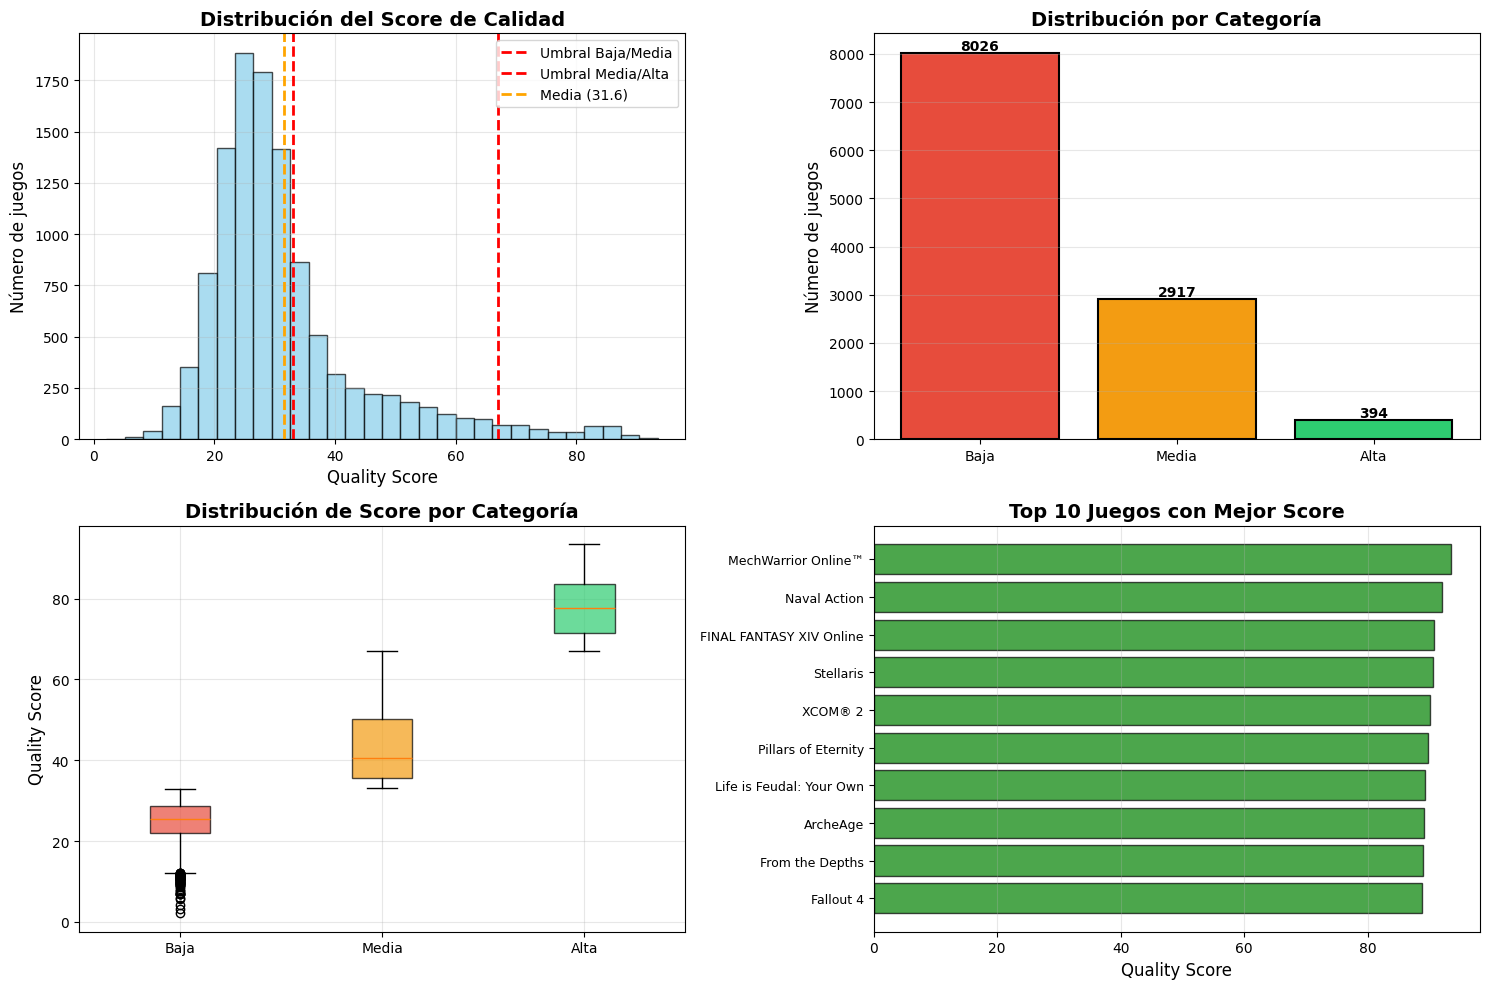


📊 Gráfico guardado: E3_distribucion_datos.png

🔍 ANÁLISIS: Impacto de la Credibilidad de Usuarios

Correlación credibilidad-quality_score: 0.2033

Juegos con ALTA credibilidad de usuarios (>2.75):
   Cantidad: 5668
   Score promedio: 33.50

Juegos con BAJA credibilidad de usuarios (<=2.75):
   Cantidad: 5669
   Score promedio: 29.68

💡 Diferencia: +3.82 puntos a favor de alta credibilidad


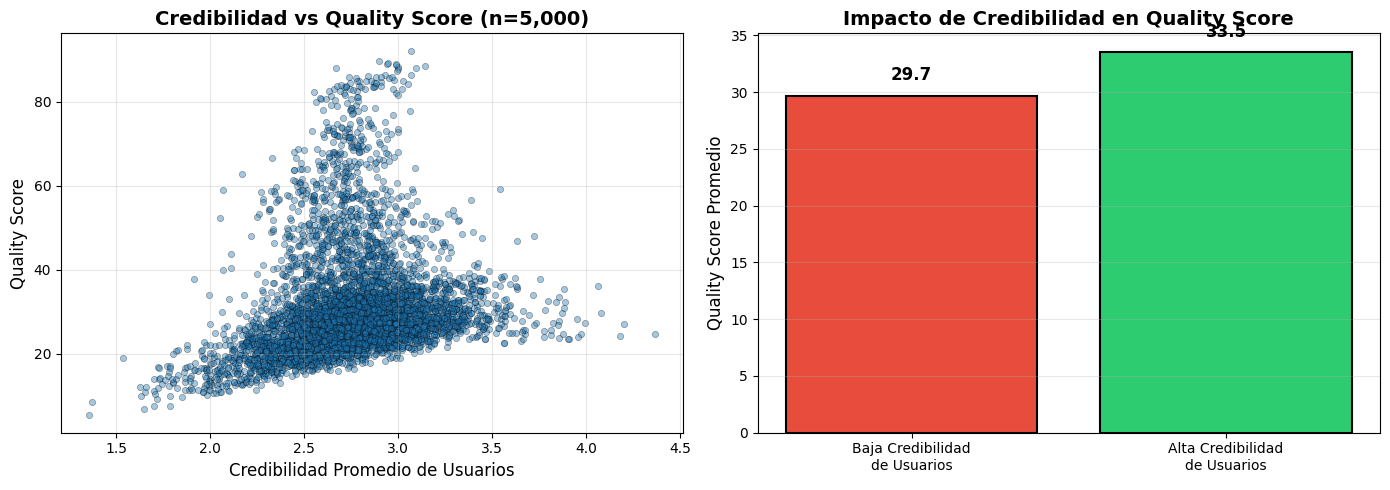


📊 Gráfico guardado: E3_impacto_credibilidad.png

✅ SCORE Y CATEGORÍAS CREADAS


In [6]:
#codigo para crear scores y categorias (etiquetas para regresion y clasificacion)
from sklearn.preprocessing import MinMaxScaler, RobustScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

print("CREANDO SCORE Y CATEGORÍAS DE CALIDAD")

#ANÁLISIS PREVIO - Detectar outliers


print("\nAnálisis de distribución de variables:")
print("\nAntes de normalizar:")
for col in ['num_reviews', 'avg_hours', 'total_useful_votes', 'avg_review_length', 'avg_user_credibility']:
    if col in game_stats_filtered.columns:
        data = game_stats_filtered[col]
        print(f"\n{col}:")
        print(f"   Media: {data.mean():.2f}")
        print(f"   Mediana: {data.median():.2f}")
        print(f"   P25: {data.quantile(0.25):.2f}")
        print(f"   P75: {data.quantile(0.75):.2f}")
        print(f"   P95: {data.quantile(0.95):.2f}")
        print(f"   Max: {data.max():.2f}")

print("\nNormalizando con manejo de outliers...")

scaler = MinMaxScaler()


def normalize_with_clipping(series, clip_percentile=95):
    """
    Normaliza con clipping de outliers extremos
    """
    # Clip valores extremos al percentil especificado
    upper_limit = series.quantile(clip_percentile / 100)
    clipped = series.clip(upper=upper_limit)
    
    # Normalizar
    normalized = scaler.fit_transform(clipped.values.reshape(-1, 1)).flatten()
    
    return normalized

#Aplicar normalización con clipping
game_stats_filtered['norm_reviews'] = normalize_with_clipping(
    game_stats_filtered['num_reviews'], clip_percentile=95
)

game_stats_filtered['norm_hours'] = normalize_with_clipping(
    game_stats_filtered['avg_hours'], clip_percentile=95
)

game_stats_filtered['norm_useful'] = normalize_with_clipping(
    game_stats_filtered['total_useful_votes'], clip_percentile=95
)

game_stats_filtered['norm_length'] = normalize_with_clipping(
    game_stats_filtered['avg_review_length'], clip_percentile=95
)

game_stats_filtered['norm_credibility'] = normalize_with_clipping(
    game_stats_filtered['avg_user_credibility'], clip_percentile=95
)

print("\nDistribución de variables normalizadas:")
for col in ['norm_reviews', 'norm_hours', 'norm_useful', 'norm_length', 'norm_credibility']:
    if col in game_stats_filtered.columns:
        print(f"{col}: Media={game_stats_filtered[col].mean():.3f}, Std={game_stats_filtered[col].std():.3f}")

#calcular quality score
print("\Calculando Quality Score...")

game_stats_filtered['quality_score'] = (
    game_stats_filtered['norm_reviews'] * 0.15 +      # 15% cantidad reviews
    game_stats_filtered['norm_hours'] * 0.25 +        # 25% horas jugadas
    game_stats_filtered['norm_useful'] * 0.25 +       # 25% votos útiles
    game_stats_filtered['norm_length'] * 0.15 +       # 15% longitud reviews
    game_stats_filtered['norm_credibility'] * 0.20    # 20% credibilidad
) * 100

print("\nQuality Score (0-100):")
print("   Factores:")
print("   • 15% - Cantidad de reviews")
print("   • 25% - Horas jugadas promedio")
print("   • 25% - Votos útiles totales")
print("   • 15% - Longitud promedio reviews")
print("   • 20% - Credibilidad promedio usuarios")

# Estadísticas del score
print(f"\nEstadísticas del Quality Score:")
print(f"   Media: {game_stats_filtered['quality_score'].mean():.2f}")
print(f"   Mediana: {game_stats_filtered['quality_score'].median():.2f}")
print(f"   Std: {game_stats_filtered['quality_score'].std():.2f}")
print(f"   Min: {game_stats_filtered['quality_score'].min():.2f}")
print(f"   P25: {game_stats_filtered['quality_score'].quantile(0.25):.2f}")
print(f"   P50: {game_stats_filtered['quality_score'].quantile(0.50):.2f}")
print(f"   P75: {game_stats_filtered['quality_score'].quantile(0.75):.2f}")
print(f"   Max: {game_stats_filtered['quality_score'].max():.2f}")

#categorias

def categorize_quality(score):
    """Convertir score continuo a 3 categorías"""
    if score < 33:
        return 0  # Baja
    elif score < 67:
        return 1  # Media
    else:
        return 2  # Alta

game_stats_filtered['quality_category'] = game_stats_filtered['quality_score'].apply(categorize_quality)

print(f"\nDistribución de categorías:")
category_names = {0: 'Baja', 1: 'Media', 2: 'Alta'}
for cat, count in game_stats_filtered['quality_category'].value_counts().sort_index().items():
    pct = count / len(game_stats_filtered) * 100
    print(f"   {category_names[cat]:6s}: {count:4d} ({pct:5.1f}%)")

#visualizaciones

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Histograma del score continuo
ax1 = axes[0, 0]
ax1.hist(game_stats_filtered['quality_score'], bins=30, edgecolor='black', alpha=0.7, color='skyblue')
ax1.axvline(33, color='red', linestyle='--', linewidth=2, label='Umbral Baja/Media')
ax1.axvline(67, color='red', linestyle='--', linewidth=2, label='Umbral Media/Alta')
ax1.axvline(game_stats_filtered['quality_score'].mean(), color='orange', linestyle='--', 
           linewidth=2, label=f"Media ({game_stats_filtered['quality_score'].mean():.1f})")
ax1.set_xlabel('Quality Score', fontsize=12)
ax1.set_ylabel('Número de juegos', fontsize=12)
ax1.set_title('Distribución del Score de Calidad', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

# 2. Barras de categorías
ax2 = axes[0, 1]
category_counts = game_stats_filtered['quality_category'].value_counts().sort_index()
colors = ['#e74c3c', '#f39c12', '#2ecc71']
bars = ax2.bar([category_names[i] for i in category_counts.index], category_counts.values, 
               color=colors, edgecolor='black', linewidth=1.5)

for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}',
            ha='center', va='bottom', fontweight='bold')

ax2.set_ylabel('Número de juegos', fontsize=12)
ax2.set_title('Distribución por Categoría', fontsize=14, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

# 3. Boxplot por categoría
ax3 = axes[1, 0]
category_data = [
    game_stats_filtered[game_stats_filtered['quality_category'] == cat]['quality_score'].values
    for cat in sorted(game_stats_filtered['quality_category'].unique())
]
bp = ax3.boxplot(category_data, labels=[category_names[i] for i in sorted(game_stats_filtered['quality_category'].unique())],
                 patch_artist=True)

for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax3.set_ylabel('Quality Score', fontsize=12)
ax3.set_title('Distribución de Score por Categoría', fontsize=14, fontweight='bold')
ax3.grid(alpha=0.3)

# 4. Top 10 juegos con mejor score
ax4 = axes[1, 1]
top_games = game_stats_filtered.nlargest(10, 'quality_score')
game_labels = [name[:30] + '...' if len(name) > 30 else name for name in top_games.index]
ax4.barh(range(len(top_games)), top_games['quality_score'], color='green', alpha=0.7, edgecolor='black')
ax4.set_yticks(range(len(top_games)))
ax4.set_yticklabels(game_labels, fontsize=9)
ax4.set_xlabel('Quality Score', fontsize=12)
ax4.set_title('Top 10 Juegos con Mejor Score', fontsize=14, fontweight='bold')
ax4.invert_yaxis()
ax4.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('E3_distribucion_datos.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nGráfico guardado: E3_distribucion_datos.png")

#analisis de credibilidad
print("ANÁLISIS: Impacto de la Credibilidad de Usuarios")


corr = game_stats_filtered['avg_user_credibility'].corr(game_stats_filtered['quality_score'])
print(f"\nCorrelación credibilidad-quality_score: {corr:.4f}")

median_cred = game_stats_filtered['avg_user_credibility'].median()
high_cred = game_stats_filtered[game_stats_filtered['avg_user_credibility'] > median_cred]
low_cred = game_stats_filtered[game_stats_filtered['avg_user_credibility'] <= median_cred]

print(f"\nJuegos con ALTA credibilidad de usuarios (>{median_cred:.2f}):")
print(f"   Cantidad: {len(high_cred)}")
print(f"   Score promedio: {high_cred['quality_score'].mean():.2f}")

print(f"\nJuegos con BAJA credibilidad de usuarios (<={median_cred:.2f}):")
print(f"   Cantidad: {len(low_cred)}")
print(f"   Score promedio: {low_cred['quality_score'].mean():.2f}")

diff = high_cred['quality_score'].mean() - low_cred['quality_score'].mean()
print(f"\nDiferencia: {diff:+.2f} puntos a favor de alta credibilidad")

# Visualización impacto credibilidad
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Scatter con muestra
sample_size = min(5000, len(game_stats_filtered))
sample_df = game_stats_filtered.sample(sample_size, random_state=42)

ax1.scatter(sample_df['avg_user_credibility'], 
            sample_df['quality_score'], 
            alpha=0.4, s=20, edgecolors='black', linewidth=0.5)
ax1.set_xlabel('Credibilidad Promedio de Usuarios', fontsize=12)
ax1.set_ylabel('Quality Score', fontsize=12)
ax1.set_title(f'Credibilidad vs Quality Score (n={sample_size:,})', fontsize=14, fontweight='bold')
ax1.grid(alpha=0.3)

# Comparación
ax2.bar(['Baja Credibilidad\nde Usuarios', 'Alta Credibilidad\nde Usuarios'],
        [low_cred['quality_score'].mean(), high_cred['quality_score'].mean()],
        color=['#e74c3c', '#2ecc71'], edgecolor='black', linewidth=1.5)
ax2.set_ylabel('Quality Score Promedio', fontsize=12)
ax2.set_title('Impacto de Credibilidad en Quality Score', fontsize=14, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

for i, v in enumerate([low_cred['quality_score'].mean(), high_cred['quality_score'].mean()]):
    ax2.text(i, v + 1, f'{v:.1f}', ha='center', va='bottom', fontweight='bold', fontsize=12)

plt.tight_layout()
plt.savefig('E3_impacto_credibilidad.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nGráfico guardado: E3_impacto_credibilidad.png")


print("SCORE Y CATEGORÍAS CREADAS")


In [6]:
#codigo para concatenar todos los tokens de todas las reviews de un mismo juego en el df de game_data (por lotes porque la RAM peta)
import time
import pickle
from tqdm import tqdm
import gc
print("CONCATENANDO REVIEWS POR LOTES (versión mejorada)")


start_time = time.time()

# Dividir juegos en lotes
BATCH_SIZE = 500
games_list = game_stats_filtered.index.tolist()
n_batches = (len(games_list) + BATCH_SIZE - 1) // BATCH_SIZE

print(f"\n{len(games_list):,} juegos divididos en {n_batches} lotes de {BATCH_SIZE}")

for batch_num in range(n_batches):
    print(f"\n{'='*80}")
    print(f"LOTE {batch_num + 1}/{n_batches}")
    print(f"{'='*80}")
    
    # Seleccionar juegos del lote
    start_idx = batch_num * BATCH_SIZE
    end_idx = min(start_idx + BATCH_SIZE, len(games_list))
    batch_games = games_list[start_idx:end_idx]
    
    print(f"Procesando juegos {start_idx} a {end_idx} ({len(batch_games)} juegos)...")
    
    # Filtrar reviews del lote
    df_reviews_batch = df_reviews[df_reviews['game_title'].isin(batch_games)]
    
    # Concatenar
    all_reviews_text = {}
    all_reviews_tokens = {}
    
    for game_title, group in tqdm(df_reviews_batch.groupby('game_title'), 
                                   desc=f"Lote {batch_num+1}",
                                   total=len(batch_games)):
        texts = group['processed_text'].dropna().astype(str).tolist()
        all_reviews_text[game_title] = ' '.join(texts)
        
        tokens = group['processed_tokens'].dropna().tolist()
        all_reviews_tokens[game_title] = [t for sublist in tokens if isinstance(sublist, list) for t in sublist]
    
    # Crear DataFrame del lote
    game_texts_batch = pd.DataFrame({
        'all_reviews_text': pd.Series(all_reviews_text),
        'all_reviews_tokens': pd.Series(all_reviews_tokens)
    })
    
    # Unir con stats
    game_stats_batch = game_stats_filtered.loc[batch_games]
    game_data_batch = game_stats_batch.join(game_texts_batch, how='inner')
    
    # Filtrar
    game_data_batch = game_data_batch[
        (game_data_batch['all_reviews_text'].notna()) & 
        (game_data_batch['all_reviews_text'].str.len() > 0)
    ].copy()
    
    # Guardar lote
    game_data_batch.to_pickle(f'datasets/game_data_batch_{batch_num}.pkl')
    print(f"Guardado: datasets/game_data_batch_{batch_num}.pkl ({len(game_data_batch)} juegos)")
    
    #liberar memoria
    del df_reviews_batch, all_reviews_text, all_reviews_tokens, game_texts_batch, game_data_batch, game_stats_batch
    gc.collect()  
    
    print(f"Lote {batch_num+1} completado")

elapsed = time.time() - start_time

print(f"TODOS LOS LOTES COMPLETADOS EN {elapsed/60:.1f} MINUTOS")

print(f"\nArchivos creados:")
for i in range(n_batches):
    print(f"   • datasets/game_data_batch_{i}.pkl")


📝 CONCATENANDO REVIEWS POR LOTES

📊 11,337 juegos divididos en 23 lotes de 500

LOTE 1/23
Procesando juegos 0 a 500 (500 juegos)...


Lote 1: 100%|██████████| 500/500 [00:00<00:00, 960.67it/s] 


✅ Lote 1 completado y guardado

LOTE 2/23
Procesando juegos 500 a 1000 (500 juegos)...


Lote 2: 100%|█████████▉| 498/500 [00:00<00:00, 587.16it/s]


✅ Lote 2 completado y guardado

LOTE 3/23
Procesando juegos 1000 a 1500 (500 juegos)...


Lote 3:  99%|█████████▉| 497/500 [00:00<00:00, 546.60it/s]


✅ Lote 3 completado y guardado

LOTE 4/23
Procesando juegos 1500 a 2000 (500 juegos)...


Lote 4: 100%|█████████▉| 499/500 [00:00<00:00, 665.63it/s]


✅ Lote 4 completado y guardado

LOTE 5/23
Procesando juegos 2000 a 2500 (500 juegos)...


Lote 5: 100%|█████████▉| 499/500 [00:00<00:00, 523.55it/s]


✅ Lote 5 completado y guardado

LOTE 6/23
Procesando juegos 2500 a 3000 (500 juegos)...


Lote 6: 100%|██████████| 500/500 [00:00<00:00, 848.24it/s]


✅ Lote 6 completado y guardado

LOTE 7/23
Procesando juegos 3000 a 3500 (500 juegos)...


Lote 7: 100%|██████████| 500/500 [00:01<00:00, 462.76it/s]


✅ Lote 7 completado y guardado

LOTE 8/23
Procesando juegos 3500 a 4000 (500 juegos)...


Lote 8: 100%|██████████| 500/500 [00:01<00:00, 478.76it/s]


✅ Lote 8 completado y guardado

LOTE 9/23
Procesando juegos 4000 a 4500 (500 juegos)...


Lote 9: 100%|█████████▉| 499/500 [00:00<00:00, 546.17it/s]


✅ Lote 9 completado y guardado

LOTE 10/23
Procesando juegos 4500 a 5000 (500 juegos)...


Lote 10: 100%|█████████▉| 498/500 [00:00<00:00, 679.18it/s]


✅ Lote 10 completado y guardado

LOTE 11/23
Procesando juegos 5000 a 5500 (500 juegos)...


Lote 11: 100%|██████████| 500/500 [00:00<00:00, 528.23it/s]


✅ Lote 11 completado y guardado

LOTE 12/23
Procesando juegos 5500 a 6000 (500 juegos)...


Lote 12: 100%|██████████| 500/500 [00:00<00:00, 838.65it/s] 


✅ Lote 12 completado y guardado

LOTE 13/23
Procesando juegos 6000 a 6500 (500 juegos)...


Lote 13: 100%|█████████▉| 499/500 [00:00<00:00, 559.05it/s]


✅ Lote 13 completado y guardado

LOTE 14/23
Procesando juegos 6500 a 7000 (500 juegos)...


Lote 14: 100%|██████████| 500/500 [00:00<00:00, 549.91it/s]


✅ Lote 14 completado y guardado

LOTE 15/23
Procesando juegos 7000 a 7500 (500 juegos)...


Lote 15: 100%|██████████| 500/500 [00:00<00:00, 837.43it/s] 


✅ Lote 15 completado y guardado

LOTE 16/23
Procesando juegos 7500 a 8000 (500 juegos)...


Lote 16: 100%|██████████| 500/500 [00:01<00:00, 490.08it/s]


✅ Lote 16 completado y guardado

LOTE 17/23
Procesando juegos 8000 a 8500 (500 juegos)...


Lote 17: 100%|█████████▉| 499/500 [00:01<00:00, 354.15it/s]


✅ Lote 17 completado y guardado

LOTE 18/23
Procesando juegos 8500 a 9000 (500 juegos)...


Lote 18: 100%|█████████▉| 499/500 [00:01<00:00, 347.81it/s]


✅ Lote 18 completado y guardado

LOTE 19/23
Procesando juegos 9000 a 9500 (500 juegos)...


Lote 19: 100%|█████████▉| 498/500 [00:01<00:00, 252.13it/s]


✅ Lote 19 completado y guardado

LOTE 20/23
Procesando juegos 9500 a 10000 (500 juegos)...


Lote 20: 100%|██████████| 500/500 [00:01<00:00, 257.80it/s]


✅ Lote 20 completado y guardado

LOTE 21/23
Procesando juegos 10000 a 10500 (500 juegos)...


Lote 21: 100%|█████████▉| 498/500 [00:01<00:00, 308.24it/s]


✅ Lote 21 completado y guardado

LOTE 22/23
Procesando juegos 10500 a 11000 (500 juegos)...


Lote 22:  99%|█████████▉| 497/500 [00:01<00:00, 283.21it/s]


✅ Lote 22 completado y guardado

LOTE 23/23
Procesando juegos 11000 a 11337 (337 juegos)...


Lote 23: 100%|██████████| 337/337 [00:00<00:00, 610.42it/s]


✅ Lote 23 completado y guardado

📦 COMBINANDO 23 LOTES

✅ COMPLETADO EN 1.7 MINUTOS
   Dataset final: 11,377 juegos
   Memoria: ~5009.9 MB

💾 Guardando resultado final...


: 

: 

In [7]:
#codigo para cargar los 5 primero batches del dataFrame de juegos (con los vectores completos de las reviews)

import pandas as pd
import time

print(" CARGANDO PRIMEROS 5 LOTES (2500 JUEGOS)")
start_time = time.time()

# Cargar los primeros 5 lotes
lotes_a_cargar = 5 
all_batches = []

for i in range(lotes_a_cargar):
    print(f"\n🔄 Cargando lote {i}...")
    batch = pd.read_pickle(f'datasets/game_data_batch_{i}.pkl')
    print(f"   ✅ Lote {i}: {len(batch):,} juegos cargados")
    all_batches.append(batch)

#Combinar en un solo DataFrame
print(f"\nCombinando {lotes_a_cargar} lotes...")
game_data = pd.concat(all_batches, axis=0)

# Resetear índice (opcional pero recomendado)
game_data = game_data.reset_index(drop=False)

elapsed = time.time() - start_time

print(f"\nDataset combinado:")
print(f"   Total juegos: {len(game_data):,}")
print(f"   Columnas: {list(game_data.columns)}")
print(f"   Memoria: ~{game_data.memory_usage(deep=True).sum() / 1024**2:.0f} MB")

print(f"\nDistribución de categorías:")
if 'quality_category' in game_data.columns:
    category_names = {0: 'Baja', 1: 'Media', 2: 'Alta'}
    for cat, count in game_data['quality_category'].value_counts().sort_index().items():
        print(f"   {category_names[cat]}: {count}")

print(f"   Variable: game_data")
print(f"   Tamaño: {len(game_data):,} juegos")

📦 CARGANDO PRIMEROS 5 LOTES (1500 JUEGOS)

🔄 Cargando lote 0...
   ✅ Lote 0: 500 juegos cargados

🔄 Cargando lote 1...
   ✅ Lote 1: 504 juegos cargados

🔄 Cargando lote 2...
   ✅ Lote 2: 506 juegos cargados

🔄 Cargando lote 3...
   ✅ Lote 3: 502 juegos cargados

🔄 Cargando lote 4...
   ✅ Lote 4: 502 juegos cargados

🔗 Combinando 5 lotes...

✅ COMPLETADO EN 3.6 SEGUNDOS

📊 Dataset combinado:
   Total juegos: 2,514
   Columnas: ['index', 'num_reviews', 'avg_hours', 'total_useful_votes', 'avg_user_credibility', 'product_id', 'avg_review_length', 'price', 'genres', 'tags', 'metascore', 'norm_reviews', 'norm_hours', 'norm_useful', 'norm_length', 'norm_credibility', 'quality_score', 'quality_category', 'all_reviews_text', 'all_reviews_tokens']
   Memoria: ~764 MB

📈 Distribución de categorías:
   Baja: 1814
   Media: 616
   Alta: 84

✅ Listo para usar!
   Variable: game_data
   Tamaño: 2,514 juegos


In [8]:
#división train/test

from sklearn.model_selection import train_test_split

X_text = game_data['all_reviews_text']
X_tokens = game_data['all_reviews_tokens']
y_score = game_data['quality_score']  #para regresión 
y_category = game_data['quality_category']  #para clasificación 

X_text_train, X_text_test, y_cat_train, y_cat_test, y_score_train, y_score_test = train_test_split(
    X_text, y_category, y_score, test_size=0.2, random_state=42, stratify=y_category
)

#también los tokens
X_tokens_train = game_data.loc[X_text_train.index, 'all_reviews_tokens']
X_tokens_test = game_data.loc[X_text_test.index, 'all_reviews_tokens']

print(f"\nTraining: {len(X_text_train):,} juegos")
print(f"Test: {len(X_text_test):,} juegos")

print(f"\nDistribución categorías (train):")
for cat, count in y_cat_train.value_counts().sort_index().items():
    print(f"   {category_names[cat]}: {count}")

print(f"\nDistribución categorías (test):")
for cat, count in y_cat_test.value_counts().sort_index().items():
    print(f"   {category_names[cat]}: {count}")


Training: 2,011 juegos
Test: 503 juegos

Distribución categorías (train):
   Baja: 1451
   Media: 493
   Alta: 67

Distribución categorías (test):
   Baja: 363
   Media: 123
   Alta: 17


In [9]:
#Bag of Words y TF-IDF
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

#bag of words
print("\nBag of Words (CountVectorizer)")
bow_vectorizer = CountVectorizer(
    max_features=1000,
    min_df=2,
    max_df=0.8
)

X_train_bow = bow_vectorizer.fit_transform(X_text_train)
X_test_bow = bow_vectorizer.transform(X_text_test)

print(f"   Vocabulario: {len(bow_vectorizer.vocabulary_):,} palabras")
print(f"   Train shape: {X_train_bow.shape}")
print(f"   Test shape: {X_test_bow.shape}")

#tf-idf
print("\nTF-IDF (TfidfVectorizer)")
tfidf_vectorizer = TfidfVectorizer(
    max_features=1000,
    min_df=2,
    max_df=0.8,
    sublinear_tf=True
)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_text_train)
X_test_tfidf = tfidf_vectorizer.transform(X_text_test)

print(f"   Vocabulario: {len(tfidf_vectorizer.vocabulary_):,} palabras")
print(f"   Train shape: {X_train_tfidf.shape}")
print(f"   Test shape: {X_test_tfidf.shape}")

print("\nRepresentaciones sparse creadas")


Bag of Words (CountVectorizer)
   Vocabulario: 1,000 palabras
   Train shape: (2011, 1000)
   Test shape: (503, 1000)

TF-IDF (TfidfVectorizer)
   Vocabulario: 1,000 palabras
   Train shape: (2011, 1000)
   Test shape: (503, 1000)

Representaciones sparse creadas


In [10]:
#Clasificadores Shallow
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_classifier(clf, X_train, X_test, y_train, y_test, name):
    """Entrena y evalúa clasificador"""
    print(f"   Entrenando {name}...")
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    rec = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    
    print(f"   ✅ {name} - Acc: {acc:.4f}, F1: {f1:.4f}")
    
    return {
        'Modelo': name,
        'Tarea': 'Clasificación',
        'Tipo': 'Shallow Learning',
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-Score': f1,
        'RMSE': np.nan,
        'R²': np.nan
    }

results = []

print("SHALLOW LEARNING - CLASIFICACIÓN CON BOW")
print("\nNaive Bayes + BoW")
nb_bow = MultinomialNB()
results.append(evaluate_classifier(nb_bow, X_train_bow, X_test_bow, y_cat_train, y_cat_test, 'NB + BoW'))

print("\nLogistic Regression + BoW")
lr_bow = LogisticRegression(max_iter=1000, random_state=42)
results.append(evaluate_classifier(lr_bow, X_train_bow, X_test_bow, y_cat_train, y_cat_test, 'LR + BoW'))

print("SHALLOW LEARNING - CLASIFICACIÓN CON TF-IDF")
print("\nNaive Bayes + TF-IDF")
nb_tfidf = MultinomialNB()
results.append(evaluate_classifier(nb_tfidf, X_train_tfidf, X_test_tfidf, y_cat_train, y_cat_test, 'NB + TF-IDF'))

print("\nLogistic Regression + TF-IDF")
lr_tfidf = LogisticRegression(max_iter=1000, random_state=42)
results.append(evaluate_classifier(lr_tfidf, X_train_tfidf, X_test_tfidf, y_cat_train, y_cat_test, 'LR + TF-IDF'))

print("\nShallow Learning (Clasificación) completado")

SHALLOW LEARNING - CLASIFICACIÓN CON BOW

Naive Bayes + BoW
   Entrenando NB + BoW...
   ✅ NB + BoW - Acc: 0.6640, F1: 0.6617

Logistic Regression + BoW
   Entrenando LR + BoW...
   ✅ LR + BoW - Acc: 0.7734, F1: 0.7744
SHALLOW LEARNING - CLASIFICACIÓN CON TF-IDF

Naive Bayes + TF-IDF
   Entrenando NB + TF-IDF...
   ✅ NB + TF-IDF - Acc: 0.7913, F1: 0.7429

Logistic Regression + TF-IDF
   Entrenando LR + TF-IDF...
   ✅ LR + TF-IDF - Acc: 0.8370, F1: 0.8154

Shallow Learning (Clasificación) completado


In [11]:
#Regresores Shallow 
'''
para generar un score de calidad personalizado" (número, no categoría).
'''
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

def evaluate_regressor(reg, X_train, X_test, y_train, y_test, name):
    """Entrena y evalúa regresor"""
    print(f"   Entrenando {name}...")
    reg.fit(X_train, y_train)
    y_pred = reg.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    print(f"{name} - R²: {r2:.4f}, RMSE: {rmse:.2f}")
    
    return {
        'Modelo': name,
        'Tarea': 'Regresión',
        'Tipo': 'Shallow Learning',
        'Accuracy': np.nan,
        'Precision': np.nan,
        'Recall': np.nan,
        'F1-Score': np.nan,
        'RMSE': rmse,
        'R²': r2
    }


print("SHALLOW LEARNING - REGRESIÓN CON TF-IDF")

print("\nRidge Regression + TF-IDF")
ridge_tfidf = Ridge(alpha=1.0, random_state=42)
results.append(evaluate_regressor(ridge_tfidf, X_train_tfidf, X_test_tfidf, y_score_train, y_score_test, 'Ridge + TF-IDF'))

print("\nRandom Forest Regressor + TF-IDF")
rf_reg_tfidf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
results.append(evaluate_regressor(rf_reg_tfidf, X_train_tfidf, X_test_tfidf, y_score_train, y_score_test, 'RF-Reg + TF-IDF'))

print("\nShallow Learning (Regresión) completado")

SHALLOW LEARNING - REGRESIÓN CON TF-IDF

Ridge Regression + TF-IDF
   Entrenando Ridge + TF-IDF...
Ridge + TF-IDF - R²: 0.6815, RMSE: 7.50

Random Forest Regressor + TF-IDF
   Entrenando RF-Reg + TF-IDF...
RF-Reg + TF-IDF - R²: 0.7457, RMSE: 6.70

Shallow Learning (Regresión) completado


In [12]:
#Word2Vec propio
from gensim.models import Word2Vec

print("DEEP LEARNING - WORD2VEC STEAM (PROPIO)")



w2v_steam = Word2Vec.load("modelos/steam_reviews_w2v_model")
print("Modelo Word2Vec Steam cargado")

print(f"   Vocabulario: {len(w2v_steam.wv):,} palabras")
print(f"   Dimensión: {w2v_steam.wv.vector_size}")

DEEP LEARNING - WORD2VEC STEAM (PROPIO)
Modelo Word2Vec Steam cargado
   Vocabulario: 257,921 palabras
   Dimensión: 200


In [13]:
#Word2Vec - Google News
import gensim.downloader as api
print("DEEP LEARNING - WORD2VEC GOOGLE NEWS (PRE-ENTRENADO)")

w2v_google = api.load('word2vec-google-news-300')
print(f"Cargado - Vocabulario: {len(w2v_google):,}, Dimensión: {w2v_google.vector_size}")


DEEP LEARNING - WORD2VEC GOOGLE NEWS (PRE-ENTRENADO)
Cargado - Vocabulario: 3,000,000, Dimensión: 300


In [14]:
#Vectorizar documentos
'''
Convierte el texto de un juego completo a UN SOLO vector.
'''
def document_to_vector(tokens, model, vector_size):
    """Convierte tokens a vector promediando embeddings"""
    vectors = []
    for token in tokens:
        if token in model:
            vectors.append(model[token])
    
    if len(vectors) == 0:
        return np.zeros(vector_size)
    
    return np.mean(vectors, axis=0)

def vectorize_dataset(token_lists, model, vector_size, desc="Vectorizando"):
    """Vectoriza dataset completo"""
    return np.array([
        document_to_vector(tokens, model, vector_size) 
        for tokens in tqdm(token_lists, desc=desc)
    ])

print("VECTORIZANDO DOCUMENTOS")
#Word2Vec Steam
print("\nCon Word2Vec Steam")
X_train_w2v_steam = vectorize_dataset(X_tokens_train, w2v_steam.wv, w2v_steam.wv.vector_size, "Train W2V Steam")
X_test_w2v_steam = vectorize_dataset(X_tokens_test, w2v_steam.wv, w2v_steam.wv.vector_size, "Test W2V Steam")
print(f"   Train: {X_train_w2v_steam.shape}, Test: {X_test_w2v_steam.shape}")

#Word2Vec Google 

print("\nCon Word2Vec Google News")
X_train_w2v_google = vectorize_dataset(X_tokens_train, w2v_google, w2v_google.vector_size, "Train W2V Google")
X_test_w2v_google = vectorize_dataset(X_tokens_test, w2v_google, w2v_google.vector_size, "Test W2V Google")
print(f"   Train: {X_train_w2v_google.shape}, Test: {X_test_w2v_google.shape}")


print("\nVectorización completada")

VECTORIZANDO DOCUMENTOS

Con Word2Vec Steam


Test W2V Steam: 100%|██████████| 503/503 [00:15<00:00, 32.21it/s]


   Train: (2011, 200), Test: (503, 200)

Con Word2Vec Google News


Test W2V Google: 100%|██████████| 503/503 [00:14<00:00, 34.40it/s]

   Train: (2011, 300), Test: (503, 300)

Vectorización completada


In [15]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
print("GPU deshabilitada")


✅ GPU deshabilitada
⚠️ IMPORTANTE: Ahora ejecuta las demás celdas


In [16]:
import tensorflow as tf

# Verificar que está usando CPU
print("Dispositivos disponibles:")
print(tf.config.list_physical_devices())
# Debe mostrar solo CPU, NO GPU

print(f"\nTensorFlow version: {tf.__version__}")

2025-11-18 09:42:34.508300: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-18 09:42:34.923424: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-18 09:45:17.142323: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Dispositivos disponibles:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

TensorFlow version: 2.20.0


2025-11-18 09:45:17.727982: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [17]:
#codigo para usar realizar una CNN
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.initializers import Constant
from sklearn.preprocessing import LabelEncoder
import numpy as np
import time

print(" DEEP LEARNING - CNN PARA CLASIFICACIÓN")

# Limpiar sesión
tf.keras.backend.clear_session()

start_time = time.time()

# Preparar secuencias
print("\nPreparando secuencias...")
MAX_WORDS = 5000
MAX_LEN = 200

tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(X_text_train)

X_train_seq = tokenizer.texts_to_sequences(X_text_train)
X_test_seq = tokenizer.texts_to_sequences(X_text_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN)
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LEN)

print(f"Secuencias preparadas: {X_train_pad.shape}")

# Preparar labels
print("\nPreparando labels...")
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_cat_train)
y_test_encoded = label_encoder.transform(y_cat_test)
y_train_cat = keras.utils.to_categorical(y_train_encoded, 3)
y_test_cat = keras.utils.to_categorical(y_test_encoded, 3)

print(f"   ✅ Labels: {y_train_cat.shape}")

# Crear matriz de embeddings
print("\nCreando matriz de embeddings...")
embedding_dim = w2v_steam.wv.vector_size
embedding_matrix = np.zeros((MAX_WORDS, embedding_dim))

words_found = 0
for word, i in tokenizer.word_index.items():
    if i < MAX_WORDS and word in w2v_steam.wv:
        embedding_matrix[i] = w2v_steam.wv[word]
        words_found += 1

print(f" Matriz embeddings: {embedding_matrix.shape}")
print(f" Palabras encontradas en W2V: {words_found}/{min(len(tokenizer.word_index), MAX_WORDS)}")

#CNN con frozen embeddings

print("CNN + W2V Steam (frozen embeddings)")

model_cnn_frozen = keras.Sequential([
    layers.Embedding(
        MAX_WORDS, 
        embedding_dim,
        embeddings_initializer=Constant(embedding_matrix),
        input_length=MAX_LEN, 
        trainable=False
    ),
    layers.Conv1D(128, 5, activation='relu'),
    layers.GlobalMaxPooling1D(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax')
], name="CNN_Frozen")

model_cnn_frozen.compile(
    optimizer='adam', 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

print(model_cnn_frozen.summary())

print("\nEntrenando CNN Frozen (esto puede tardar ~2-3 minutos)...")
history_cnn_frozen = model_cnn_frozen.fit(
    X_train_pad, y_train_cat, 
    epochs=15, 
    batch_size=32, 
    validation_split=0.2, 
    verbose=1
)

print("\nEvaluando CNN Frozen...")
y_pred_cnn_frozen = model_cnn_frozen.predict(X_test_pad, verbose=0)
y_pred_cnn_frozen_classes = np.argmax(y_pred_cnn_frozen, axis=1)

acc = accuracy_score(y_test_encoded, y_pred_cnn_frozen_classes)
prec = precision_score(y_test_encoded, y_pred_cnn_frozen_classes, average='weighted', zero_division=0)
rec = recall_score(y_test_encoded, y_pred_cnn_frozen_classes, average='weighted', zero_division=0)
f1 = f1_score(y_test_encoded, y_pred_cnn_frozen_classes, average='weighted', zero_division=0)

print(f"\nCNN Frozen Results:")
print(f"   Accuracy:  {acc:.4f}")
print(f"   Precision: {prec:.4f}")
print(f"   Recall:    {rec:.4f}")
print(f"   F1-Score:  {f1:.4f}")

results.append({
    'Modelo': 'CNN + W2V Steam (frozen)',
    'Tarea': 'Clasificación',
    'Tipo': 'Deep Learning',
    'Accuracy': acc, 'Precision': prec, 'Recall': rec, 'F1-Score': f1,
    'RMSE': np.nan, 'R²': np.nan
})

#CNN con FINE-TUNED embeddings
print("CNN + W2V Steam (embeddings fine-tuneados)")

model_cnn_finetuned = keras.Sequential([
    layers.Embedding(
        MAX_WORDS, 
        embedding_dim,
        embeddings_initializer=Constant(embedding_matrix),
        input_length=MAX_LEN, 
        trainable=True
    ),
    layers.Conv1D(128, 5, activation='relu'),
    layers.GlobalMaxPooling1D(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax')
], name="CNN_Finetuned")

model_cnn_finetuned.compile(
    optimizer='adam', 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

print("\nEntrenando CNN Fine-tuned (esto puede tardar ~3-4 minutos)...")
history_cnn_finetuned = model_cnn_finetuned.fit(
    X_train_pad, y_train_cat, 
    epochs=15, 
    batch_size=32, 
    validation_split=0.2, 
    verbose=1
)

print("\nEvaluando CNN Fine-tuned...")
y_pred_cnn_finetuned = model_cnn_finetuned.predict(X_test_pad, verbose=0)
y_pred_cnn_finetuned_classes = np.argmax(y_pred_cnn_finetuned, axis=1)

acc = accuracy_score(y_test_encoded, y_pred_cnn_finetuned_classes)
prec = precision_score(y_test_encoded, y_pred_cnn_finetuned_classes, average='weighted', zero_division=0)
rec = recall_score(y_test_encoded, y_pred_cnn_finetuned_classes, average='weighted', zero_division=0)
f1 = f1_score(y_test_encoded, y_pred_cnn_finetuned_classes, average='weighted', zero_division=0)

print(f"\nCNN Fine-tuned Results:")
print(f"   Accuracy:  {acc:.4f}")
print(f"   Precision: {prec:.4f}")
print(f"   Recall:    {rec:.4f}")
print(f"   F1-Score:  {f1:.4f}")

results.append({
    'Modelo': 'CNN + W2V Steam (finetuned)',
    'Tarea': 'Clasificación',
    'Tipo': 'Deep Learning',
    'Accuracy': acc, 'Precision': prec, 'Recall': rec, 'F1-Score': f1,
    'RMSE': np.nan, 'R²': np.nan
})

elapsed = time.time() - start_time
print("CNN completada")

🚀 DEEP LEARNING - CNN PARA CLASIFICACIÓN

1️⃣ Preparando secuencias...
   ✅ Secuencias preparadas: (2011, 200)

2️⃣ Preparando labels...
   ✅ Labels: (2011, 3)

3️⃣ Creando matriz de embeddings...
   ✅ Matriz embeddings: (5000, 200)
   📊 Palabras encontradas en W2V: 4999/5000

4️⃣ CNN + W2V Steam (frozen embeddings)


Model: "CNN_Frozen"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None

🔄 Entrenando CNN Frozen (esto puede tardar ~2-3 minutos)...
Epoch 1/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.6082 - loss: 1.9683 - val_accuracy: 0.7047 - val_loss: 0.8154
Epoch 2/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7195 - loss: 0.6917 - val_accuracy: 0.7022 - val_loss: 0.7155
Epoch 3/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7488 - loss: 0.5888 - val_accuracy: 0.7072 - val_loss: 0.7256
Epoch 4/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7755 - loss: 0.5197 - val_accuracy: 0.7072 - val_loss: 0.6954
Epoch 5/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8116 - loss: 0.4581 - val_accuracy: 0.7072 - val_loss: 0.6753
Epoch 6/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8476 - loss: 0.3714 - val_accuracy: 0.7072 - val_loss: 0.7275
Epoch 7/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8657 - loss: 0.3133 - val_accuracy: 0.6998 - val_loss: 0.6762
Epoch 8/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms

In [18]:
#LSTM (Recurrent Neural Network)
print("DEEP LEARNING - LSTM (RNN)")
#LSTM para clasificación
print("\nLSTM + W2V Steam (embeddings congelados)")

model_lstm = keras.Sequential([
    layers.Embedding(MAX_WORDS, embedding_dim, weights=[embedding_matrix], 
                    input_length=MAX_LEN, trainable=False),
    layers.LSTM(64, dropout=0.2, recurrent_dropout=0.2),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax')
], name="LSTM")

model_lstm.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history_lstm = model_lstm.fit(
    X_train_pad, y_train_cat, epochs=10, batch_size=32, validation_split=0.2, verbose=0
)

y_pred_lstm = model_lstm.predict(X_test_pad, verbose=0)
y_pred_lstm_classes = np.argmax(y_pred_lstm, axis=1)

acc = accuracy_score(y_test_encoded, y_pred_lstm_classes)
prec = precision_score(y_test_encoded, y_pred_lstm_classes, average='weighted', zero_division=0)
rec = recall_score(y_test_encoded, y_pred_lstm_classes, average='weighted', zero_division=0)
f1 = f1_score(y_test_encoded, y_pred_lstm_classes, average='weighted', zero_division=0)

print(f"LSTM - Acc: {acc:.4f}, F1: {f1:.4f}")

results.append({
    'Modelo': 'LSTM + W2V Steam',
    'Tarea': 'Clasificación',
    'Tipo': 'Deep Learning',
    'Accuracy': acc, 'Precision': prec, 'Recall': rec, 'F1-Score': f1,
    'RMSE': np.nan, 'R²': np.nan
})

print("\nLSTM completada")

DEEP LEARNING - LSTM (RNN)

LSTM + W2V Steam (embeddings congelados)
LSTM - Acc: 0.6839, F1: 0.6243

LSTM completada


In [19]:
#Tabla comparativa
print("TABLA COMPARATIVA DE RESULTADOS")


# Crear DataFrame
results_df = pd.DataFrame(results)

# Separar por tarea
results_clasificacion = results_df[results_df['Tarea'] == 'Clasificación'].sort_values('F1-Score', ascending=False)
results_regresion = results_df[results_df['Tarea'] == 'Regresión'].sort_values('R²', ascending=False)

print("CLASIFICACIÓN ")

print(results_clasificacion[['Modelo', 'Tipo', 'Accuracy', 'Precision', 'Recall', 'F1-Score']].to_string(index=False))

print("REGRESIÓN - SCORE DE CALIDAD")

print(results_regresion[['Modelo', 'Tipo', 'RMSE', 'R²']].to_string(index=False))

#guardar CSV
results_df.to_csv('E3_resultados_completos.csv', index=False)
print("\nResultados guardados: E3_resultados_completos.csv")

#analisis
print("MEJORES MODELOS")
best_clf = results_clasificacion.iloc[0]
print(f"\nMejor Clasificación: {best_clf['Modelo']}")
print(f"   F1-Score: {best_clf['F1-Score']:.4f}")
print(f"   Accuracy: {best_clf['Accuracy']:.4f}")

if len(results_regresion) > 0:
    best_reg = results_regresion.iloc[0]
    print(f"\nMejor Regresión: {best_reg['Modelo']}")
    print(f"   R²: {best_reg['R²']:.4f}")
    print(f"   RMSE: {best_reg['RMSE']:.2f}")

#comparación Shallow vs Deep
print("SHALLOW vs DEEP LEARNING (Clasificación)")

for tipo in ['Shallow Learning', 'Deep Learning']:
    tipo_results = results_clasificacion[results_clasificacion['Tipo'] == tipo]
    if len(tipo_results) > 0:
        print(f"\n{tipo}:")
        print(f"   F1-Score promedio: {tipo_results['F1-Score'].mean():.4f}")
        print(f"   Mejor modelo: {tipo_results.iloc[0]['Modelo']}")

TABLA COMPARATIVA DE RESULTADOS
CLASIFICACIÓN 
                     Modelo             Tipo  Accuracy  Precision   Recall  F1-Score
                LR + TF-IDF Shallow Learning  0.836978   0.800219 0.836978  0.815368
                   LR + BoW Shallow Learning  0.773360   0.775420 0.773360  0.774356
                NB + TF-IDF Shallow Learning  0.791252   0.744858 0.791252  0.742930
CNN + W2V Steam (finetuned)    Deep Learning  0.711730   0.644602 0.711730  0.666265
                   NB + BoW Shallow Learning  0.664016   0.685175 0.664016  0.661719
   CNN + W2V Steam (frozen)    Deep Learning  0.719682   0.640045 0.719682  0.659980
           LSTM + W2V Steam    Deep Learning  0.683897   0.593887 0.683897  0.624263
REGRESIÓN - SCORE DE CALIDAD
         Modelo             Tipo     RMSE       R²
RF-Reg + TF-IDF Shallow Learning 6.698775 0.745735
 Ridge + TF-IDF Shallow Learning 7.497369 0.681496

Resultados guardados: E3_resultados_completos.csv
MEJORES MODELOS

Mejor Clasificación: LR

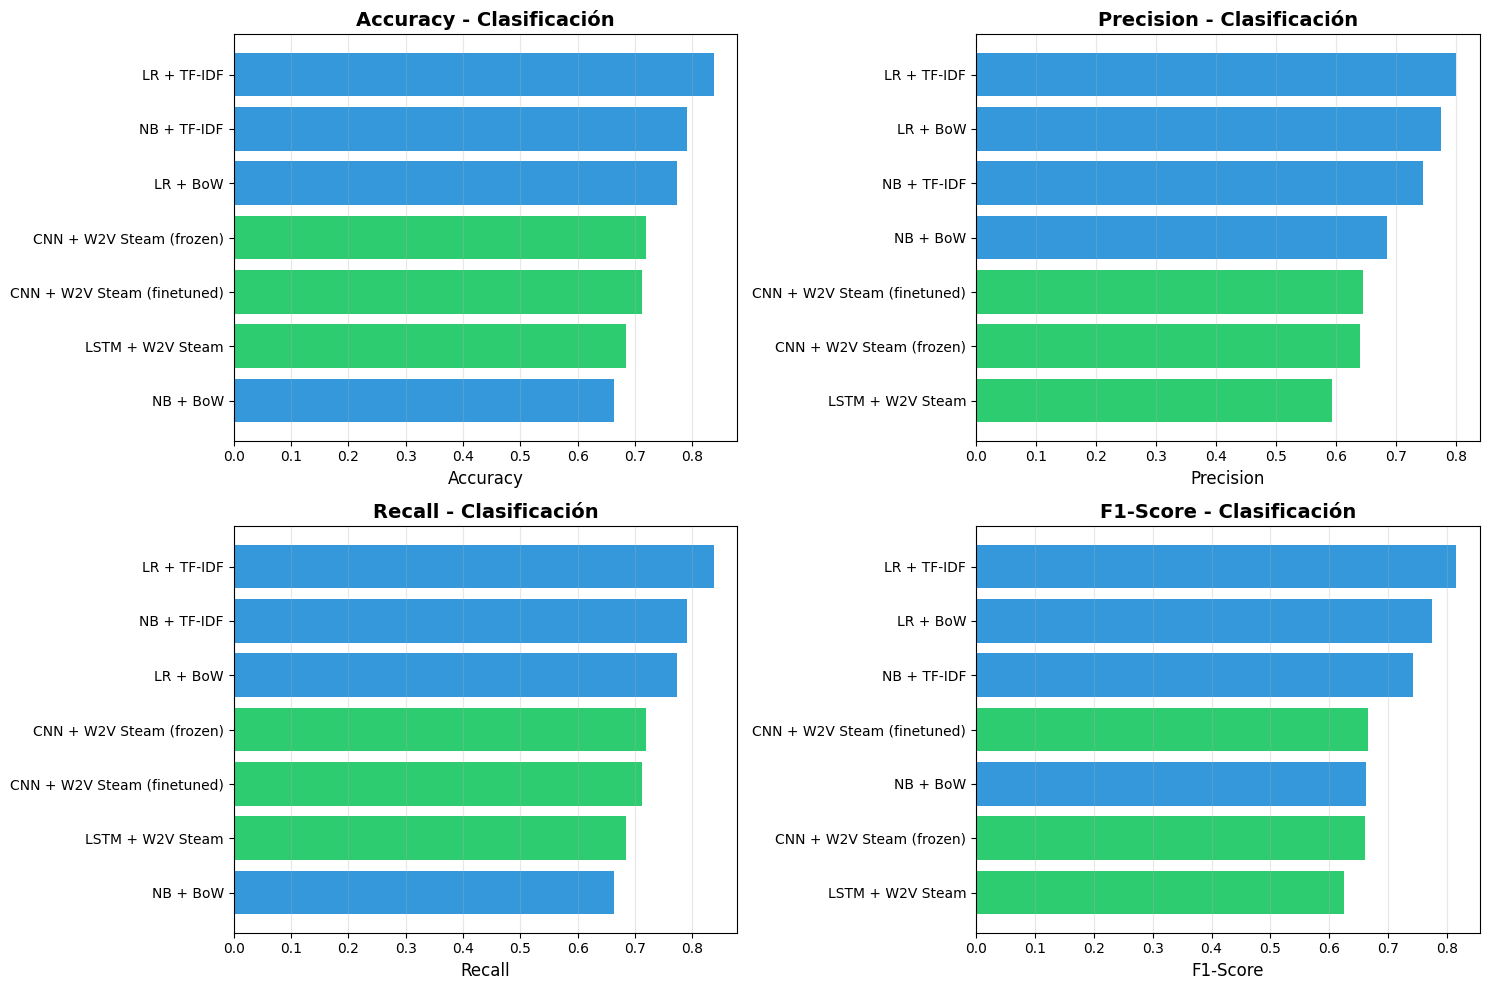

Guardado: E3_clasificacion_comparativa.png


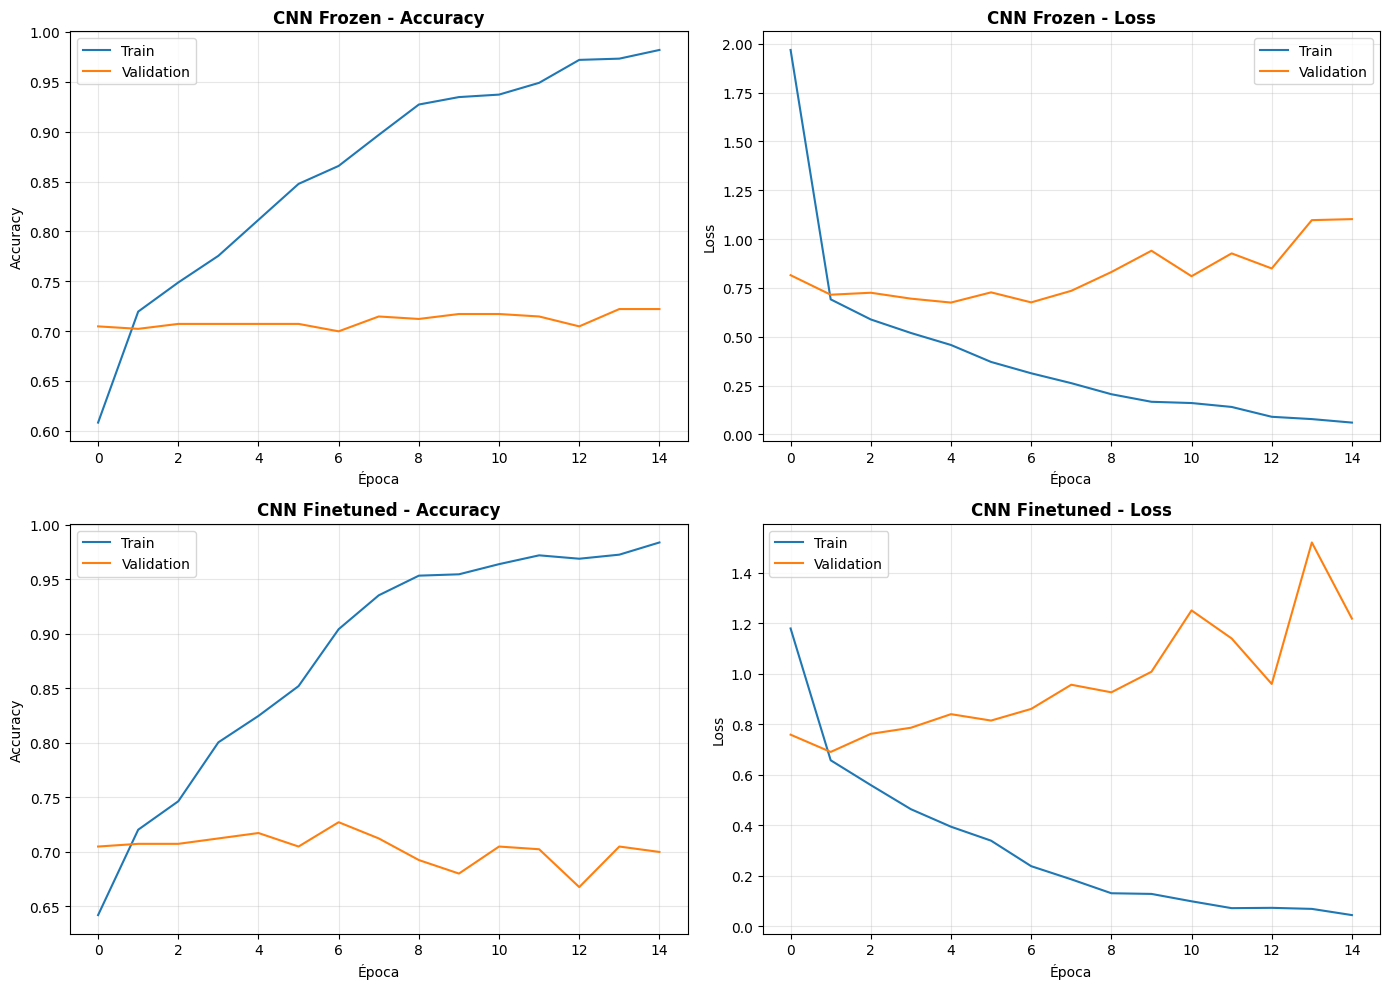

Guardado: E3_curvas_aprendizaje.png


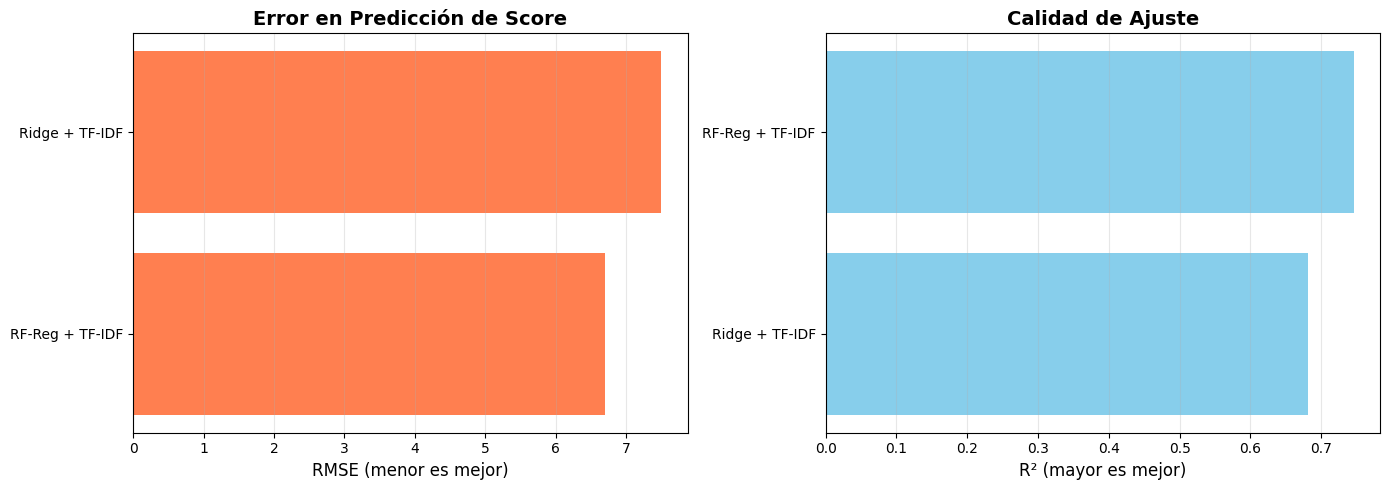

Guardado: E3_regresion_comparativa.png


In [20]:
#Visualizaciones

#gráfico comparativo de clasificación
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    
    results_sorted = results_clasificacion.sort_values(metric, ascending=True)
    colors = ['#3498db' if t == 'Shallow Learning' else '#2ecc71' for t in results_sorted['Tipo']]
    
    ax.barh(results_sorted['Modelo'], results_sorted[metric], color=colors)
    ax.set_xlabel(metric, fontsize=12)
    ax.set_title(f'{metric} - Clasificación', fontsize=14, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('E3_clasificacion_comparativa.png', dpi=300, bbox_inches='tight')
plt.show()

print("Guardado: E3_clasificacion_comparativa.png")

#curvas de aprendizaje CNN
if 'history_cnn_frozen' in globals():
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 10))
    
    #CNN Frozen
    ax1.plot(history_cnn_frozen.history['accuracy'], label='Train')
    ax1.plot(history_cnn_frozen.history['val_accuracy'], label='Validation')
    ax1.set_title('CNN Frozen - Accuracy', fontweight='bold')
    ax1.set_xlabel('Época')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(alpha=0.3)
    
    ax2.plot(history_cnn_frozen.history['loss'], label='Train')
    ax2.plot(history_cnn_frozen.history['val_loss'], label='Validation')
    ax2.set_title('CNN Frozen - Loss', fontweight='bold')
    ax2.set_xlabel('Época')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(alpha=0.3)
    
    #CNN Finetuned
    ax3.plot(history_cnn_finetuned.history['accuracy'], label='Train')
    ax3.plot(history_cnn_finetuned.history['val_accuracy'], label='Validation')
    ax3.set_title('CNN Finetuned - Accuracy', fontweight='bold')
    ax3.set_xlabel('Época')
    ax3.set_ylabel('Accuracy')
    ax3.legend()
    ax3.grid(alpha=0.3)
    
    ax4.plot(history_cnn_finetuned.history['loss'], label='Train')
    ax4.plot(history_cnn_finetuned.history['val_loss'], label='Validation')
    ax4.set_title('CNN Finetuned - Loss', fontweight='bold')
    ax4.set_xlabel('Época')
    ax4.set_ylabel('Loss')
    ax4.legend()
    ax4.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('E3_curvas_aprendizaje.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("Guardado: E3_curvas_aprendizaje.png")

#regresion
if len(results_regresion) > 0:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    #RMSE
    results_sorted = results_regresion.sort_values('RMSE', ascending=True)
    ax1.barh(results_sorted['Modelo'], results_sorted['RMSE'], color='coral')
    ax1.set_xlabel('RMSE (menor es mejor)', fontsize=12)
    ax1.set_title('Error en Predicción de Score', fontsize=14, fontweight='bold')
    ax1.grid(axis='x', alpha=0.3)
    
    #R²
    results_sorted = results_regresion.sort_values('R²', ascending=True)
    ax2.barh(results_sorted['Modelo'], results_sorted['R²'], color='skyblue')
    ax2.set_xlabel('R² (mayor es mejor)', fontsize=12)
    ax2.set_title('Calidad de Ajuste', fontsize=14, fontweight='bold')
    ax2.grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('E3_regresion_comparativa.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("Guardado: E3_regresion_comparativa.png")


Analizando: LR + TF-IDF


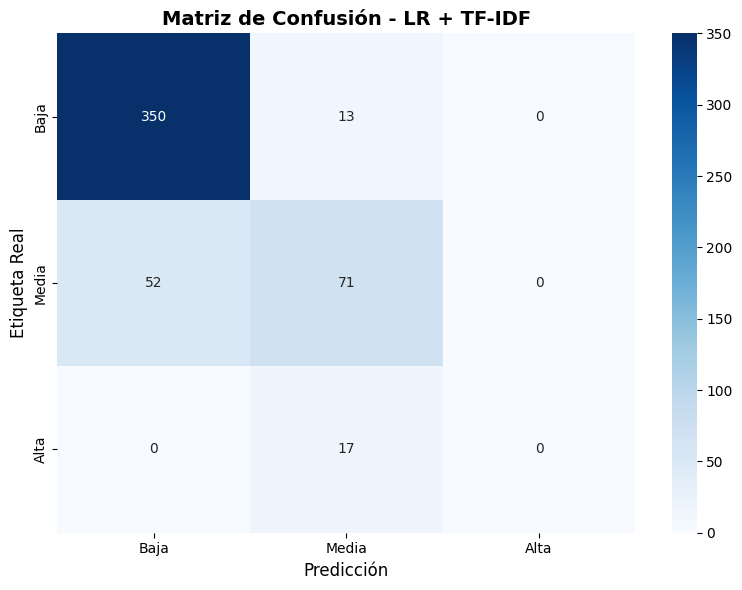


Guardado: E3_confusion_matrix.png
CLASSIFICATION REPORT - LR + TF-IDF
               precision    recall  f1-score   support

 Baja Calidad       0.87      0.96      0.92       363
Media Calidad       0.70      0.58      0.63       123
 Alta Calidad       0.00      0.00      0.00        17

     accuracy                           0.84       503
    macro avg       0.52      0.51      0.52       503
 weighted avg       0.80      0.84      0.82       503



In [21]:
#Matriz de confusión
from sklearn.metrics import confusion_matrix, classification_report

best_model_name = results_clasificacion.iloc[0]['Modelo']
print(f"\nAnalizando: {best_model_name}")

#obtener predicciones según el mejor modelo
if 'CNN' in best_model_name and 'finetuned' in best_model_name:
    y_pred_best = y_pred_cnn_finetuned_classes
elif 'CNN' in best_model_name and 'frozen' in best_model_name:
    y_pred_best = y_pred_cnn_frozen_classes
elif 'LSTM' in best_model_name:
    y_pred_best = y_pred_lstm_classes
else:
    #modelos shallow
    if 'BoW' in best_model_name:
        X_for_pred = X_test_bow
    else:
        X_for_pred = X_test_tfidf
    
    if 'NB' in best_model_name:
        clf = nb_tfidf if 'TF-IDF' in best_model_name else nb_bow
    else:
        clf = lr_tfidf if 'TF-IDF' in best_model_name else lr_bow
    
    y_pred_best = clf.predict(X_for_pred)

#matriz de confusión
cm = confusion_matrix(y_cat_test, y_pred_best)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Baja', 'Media', 'Alta'],
            yticklabels=['Baja', 'Media', 'Alta'])
plt.title(f'Matriz de Confusión - {best_model_name}', fontsize=14, fontweight='bold')
plt.ylabel('Etiqueta Real', fontsize=12)
plt.xlabel('Predicción', fontsize=12)
plt.tight_layout()
plt.savefig('E3_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nGuardado: E3_confusion_matrix.png")

#classification report
print(f"CLASSIFICATION REPORT - {best_model_name}")

print(classification_report(y_cat_test, y_pred_best, 
                          target_names=['Baja Calidad', 'Media Calidad', 'Alta Calidad']))

ANÁLISIS DE PREDICCIÓN DE SCORE (E1)


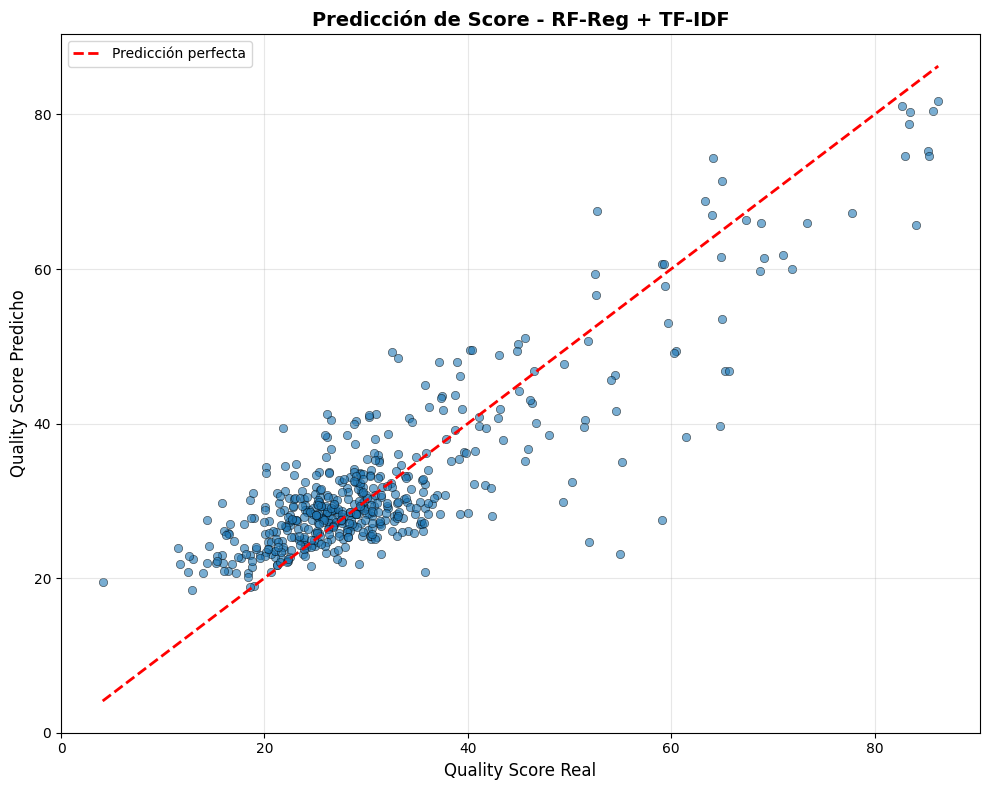

Guardado: E3_prediccion_score.png
EJEMPLOS DE PREDICCIONES DE SCORE
 Juego  Score Real  Score Predicho     Error
  2412   45.612667       35.175377 10.437290
  1994   28.847874       29.604857  0.756984
  1186   23.297817       26.355736  3.057919
   681   27.251336       28.547770  1.296434
   183   29.687656       29.333446  0.354210
  1644   29.915685       29.101389  0.814296
   258    4.096827       19.524771 15.427944
  1224   31.887881       27.503572  4.384309
  1458   33.614933       27.823337  5.791596
  1940   25.376409       33.783346  8.406937


In [22]:
#análisis de predicciones
if len(results_regresion) > 0:
    print("ANÁLISIS DE PREDICCIÓN DE SCORE (E1)")

    
    #usar mejor modelo de regresión
    best_reg_name = results_regresion.iloc[0]['Modelo']
    
    if 'Ridge' in best_reg_name:
        y_pred_score = ridge_tfidf.predict(X_test_tfidf)
    else:
        y_pred_score = rf_reg_tfidf.predict(X_test_tfidf)
    
    #gráfico real vs predicho
    plt.figure(figsize=(10, 8))
    plt.scatter(y_score_test, y_pred_score, alpha=0.6, edgecolors='black', linewidth=0.5)
    plt.plot([y_score_test.min(), y_score_test.max()], 
             [y_score_test.min(), y_score_test.max()], 
             'r--', lw=2, label='Predicción perfecta')
    plt.xlabel('Quality Score Real', fontsize=12)
    plt.ylabel('Quality Score Predicho', fontsize=12)
    plt.title(f'Predicción de Score - {best_reg_name}', fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig('E3_prediccion_score.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("Guardado: E3_prediccion_score.png")
    
    #ejemplos de predicciones
    print("EJEMPLOS DE PREDICCIONES DE SCORE")

    
    predictions_df = pd.DataFrame({
        'Juego': X_text_test.index[:10],
        'Score Real': y_score_test[:10].values,
        'Score Predicho': y_pred_score[:10],
        'Error': np.abs(y_score_test[:10].values - y_pred_score[:10])
    })
    
    print(predictions_df.to_string(index=False))